# Single-site sorted spike shapes

author: laquitainesteeve@gmail.com

Validation of sorted spike shapes

A good fit of power law requires typically at least a range of frequency of 2 orders of magnitude, we high-pass filter with a cutoff of 100 Hz, and apply common referencing, then fit a power law to the power spectral density between 100 Hz and 10 KHz.

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz)

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download recordings: "_notebooks/0_download_recordings.ipynb_"
3. Download sortings: "_notebooks/0_download_sortings.ipynb_"
4. Or Spike sort with: 
    - "_src/pipes/sorting/npx_spont/10m/ks3.py_" 
    - "_src/pipes/sorting/npx_evoked/10m/ks3.py_"

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

# import libs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
from concurrent.futures import ProcessPoolExecutor
from ipywidgets import interactive, widgets
import spikeinterface.core.template_tools as ttools
import spikeinterface as si
from spikeinterface import extract_waveforms
import spikeinterface.preprocessing as spre
from concurrent.futures import ThreadPoolExecutor
import itertools
print('Spikeinterface version:', si.__version__)

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.postpro import waveform
from src.nodes.prepro.run import run as prep

# SETUP PARAMETERS
MS_BEFORE = 6           # ms
MS_AFTER = 6            # ms
MS_BEFORE_NEW = 1.25   
MS_AFTER_NEW = 1.25

# biophy npx spont 
RAW_PATH = os.path.join(PROJ_PATH, "dataset/00_raw/recording_npx_spont")
PREP_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/preprocessing/recording_npx_spont")
WAVE_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/waveforms/npx_spont/SortingKS3") 
SORT_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/sorting/npx_spont/SortingKS3")

# biophy npx evoked
RAW_PATH_E = os.path.join(PROJ_PATH, "dataset/00_raw/recording_npx_evoked")
PREP_PATH_E = os.path.join(PROJ_PATH, "dataset/01_intermediate/preprocessing/recording_npx_evoked")
WAVE_PATH_E = os.path.join(PROJ_PATH, "dataset/01_intermediate/waveforms/npx_evoked/SortingKS3") 
SORT_PATH_E = os.path.join(PROJ_PATH, "dataset/01_intermediate/sorting/npx_evoked/SortingKS3")

# set parameters
REC_SECS = 600 #1800        # (30 min) duration of recording (longer produces kernel crash)
FREQ_MIN = 300              # lower cutoff of bandpass filtering
FREQ_MAX = 3000 #6000             # 10000 (Paulk, NNeuro, 2022); 6000 Hz (Buccino); 14,250 Hz (Sun JNp, 2022)
SAVE_REC = False            # save preprocessed recording
LOAD_WE_IF_EXISTS = False   # load waveforms if already extracted
N_JOBS = 20                 # (default = 20) number of parallel processes for waveform extraction (20/32)
CHUNKS = 50000             # (default = 800000) use smaller chunks to use less RAM
MAX_SPIKES_PER_UNIT = 500   # (default = 500) max number of spikes used per unit
WE_JOB_KWARGS = dict(n_jobs=N_JOBS, chunk_size=800000, progress_bar=True)
SAVE_FIG = True

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Spikeinterface version: 0.100.5
CPU times: user 279 µs, sys: 207 µs, total: 486 µs
Wall time: 501 µs


## Clear RAM

In [87]:
# clear RAM
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: 

## Functions

In [124]:
def get_waveforms(rec_secs, ms_before, ms_after, freq_min, freq_max, n_jobs, chunks, load_we_if_exists, we_job_kwargs, raw_path, prep_path, sort_path, wave_path):
    """Extract waveforms

    Args:
        rec_secs (_type_): duration of sample recording in seconds
        ms_before (_type_): period before waveform timestamp in ms
        ms_after (_type_): period after waveform timestamp in ms
        freq_min (_type_): lower cutoff of bandpass filtering
        freq_max (_type_): higher cutoff
        n_jobs (_type_): number of processes (parallel processing)
        chunks (_type_): sample size of each processed chunk (parallel processing)
        load_we_if_exists (_type_): load waveform extractors if already exists
        we_job_kwargs (_type_): parameters of waveform extraction (parallel processing)
        raw_path (_type_): raw (noise fitted) recording path
        prep_path (_type_):  write path for preprocessed recording
        sort_path (_type_): load path of sorting extractor
        wave_path (_type_): write path for waveform extractor 

    Returns:
        _type_: Waveform extractor object
    """
    # load recording
    Recording = si.load_extractor(raw_path)
    #Recording = spre.astype(Recording, "int16")

    # sample first 10 min of recording
    sfreq = Recording.sampling_frequency
    Recording = Recording.frame_slice(start_frame=0, end_frame=sfreq*rec_secs)

    # preprocess recording
    Recording = prep(Recording, freq_min=freq_min, freq_max=freq_max)
    Recording = spre.whiten(Recording, dtype='float32') # requires float

    # TODO: whiten 
    
    # save recording
    if SAVE_REC:
        Recording = spre.astype(Recording, "int16")
        Recording.save(folder=prep_path, n_jobs=n_jobs, 
                    verbose=True, progress_bar=True, overwrite=True, 
                    dtype="float32", chunk_size=chunks)

    # load sorting
    Sorting = si.load_extractor(sort_path)
    Sorting = Sorting.frame_slice(start_frame=0, end_frame=sfreq*rec_secs)

    # extract waveforms (5 GB)
    # warning: crashes for sparse=False and more than 10 min recording
    We = extract_waveforms(Recording, Sorting, wave_path, 
                        sparse=True, ms_before=ms_before,
                        ms_after=ms_after, max_spikes_per_unit=500,
                        unit_batch_size=chunks, overwrite=True if load_we_if_exists==False else False,
                        seed=0, load_if_exists=load_we_if_exists, **we_job_kwargs)

    # get single units
    single_units = Sorting.get_property("KSLabel") == "good"
    single_units = We.unit_ids[single_units]
    print("number of single-units:", len(single_units))
    print("single units:", single_units)
    return We, single_units


def plot_batched_cell_waveforms(
    We,
    single_units,
    duration_ms=2.5,
    NSPIKE=20,
    cells_per_fig=9,
    peak_sign="neg",
    colors=((0.5, 0.5, 0.5), (0, 0, 0)),
    linewdth=1.5,
    linewidth_mean=2,
    figsize=(6, 6)
):
    centered_len = 100
    half_len = centered_len // 2
    sample_ix = get_samples_for_duration(duration_ms, We)
    ms_before = -duration_ms / 2
    ms_after = duration_ms / 2
    time_axis = np.linspace(ms_before, ms_after, num=centered_len)

    # Get max channel per cell
    max_chids = ttools.get_template_extremum_channel(We, peak_sign=peak_sign)

    cell_ids = single_units
    n_batches = int(np.ceil(len(cell_ids) / cells_per_fig))

    for batch_idx in range(n_batches):
        fig, axs = plt.subplots(3, 3, figsize=figsize)
        axs = axs.flatten()

        for i in range(cells_per_fig):
            cell_idx = batch_idx * cells_per_fig + i
            if cell_idx >= len(cell_ids):
                axs[i].axis('off')
                continue

            cell_id = cell_ids[cell_idx]
            max_site_ix = get_max_site_id(We, cell_id)

            full_tmp = We.get_template(cell_id)
            peak_ix = np.argmin(full_tmp[:, max_site_ix])
            start_ix = max(0, peak_ix - half_len)
            end_ix = start_ix + centered_len
            if end_ix > full_tmp.shape[0]:
                end_ix = full_tmp.shape[0]
                start_ix = end_ix - centered_len
            extract_ix = np.arange(start_ix, end_ix)

            waveform = We.get_waveforms(cell_id)[:, extract_ix, :]
            each_wvf = waveform[:NSPIKE, :, max_site_ix].T
            tmp = full_tmp[extract_ix, :]

            axs[i].plot(time_axis, each_wvf, color=colors[0], lw=linewdth, alpha=0.2)
            axs[i].plot(time_axis, tmp[:, max_site_ix], color=colors[1], lw=linewidth_mean)

            axs[i].set_title(f"Cell {cell_id}, Ch {int(max_chids[cell_id])}", fontsize=9)
            axs[i].set_xlabel("Time (ms)", fontsize=8)
            axs[i].set_ylabel("Potential (V)", fontsize=8)
            axs[i].tick_params(labelsize=7)

        plt.tight_layout()
        plt.show()
        print("Batch", batch_idx + 1, "/", n_batches, "| Samples in window:", len(sample_ix))
    return ms_before, ms_after, centered_len, max_chids


def get_unit_largest_median_templates_parall(dummy, args):

    cell_id, We = args

    N_SPIKES = 1

    # get waveforms
    wfs = We.get_waveforms(cell_id)
    n_sites =  wfs.shape[2]

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(n_sites):
        template = np.median(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest average spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike


def get_unit_largest_mean_templates_parallelized(dummy, args):

    cell_id, We = args
    
    N_SPIKES = 1

    # get waveforms
    wfs = We.get_waveforms(cell_id)
    n_sites =  wfs.shape[2]

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(n_sites):
        template = np.mean(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest average spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike


def update_plot(unit, single_units, We):
    """plot unit spike template

    Args:
        unit (_type_): _description_
    """
    # select unit to display
    unit_id = single_units[unit]
    print("unit id:", unit_id)

    # compute unit's max template
    with ProcessPoolExecutor() as executor:
    #with ThreadPoolExecutor() as executor:
        site_median_templates = executor.map(
            get_unit_largest_median_templates_parall,
            np.arange(0, 1, 1),
            [(unit_id, We)],
        )    
    site_median_templates = list(site_median_templates)

    # format for wavemap
    median_templates_for_wavemap = np.array(site_median_templates[0].tolist())

    # compute unit's max mean template
    with ProcessPoolExecutor() as executor:
    #with ThreadPoolExecutor() as executor:
        site_mean_templates = executor.map(
            get_unit_largest_mean_templates_parallelized,
            np.arange(0, 1, 1),
            [(unit_id, We)],
        )
    site_mean_templates = list(site_mean_templates)

    # format for wavemap
    mean_templates_for_wavemap = np.array(site_mean_templates[0].tolist())

    # plot
    f, axis = plt.subplots(nrows=1, figsize=(4, 4))
    axis.plot(median_templates_for_wavemap)
    axis.plot(mean_templates_for_wavemap, "r")
    axis.set_xticks([0, len(mean_templates_for_wavemap)/2, len(mean_templates_for_wavemap)],[-MS_BEFORE,0, MS_AFTER])
    axis.set_xlabel("Time (ms)")
    plt.show()


def get_max_site_id(We, cell_id):
    """get index of max site id, among the sparse subset of 
    sites used for the waveform"""
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign="both"
    )
    c_ids = We.sparsity.unit_id_to_channel_ids[cell_id]
    max_chid = max_chids[cell_id]
    return np.where(c_ids == max_chid)[0][0]


def get_samples_for_duration(duration_ms, We):
    n_sp_before = duration_ms/1000/2 * We.sampling_frequency 
    n_sp_after = n_sp_before
    center_sp = We.nsamples/2
    sp_start = int(center_sp - n_sp_before)
    sp_end = int(center_sp + n_sp_after)
    return np.arange(sp_start, sp_end, 1)


def plot_centered_waveform(
    We,
    cell_id,
    nspike=100,
    centered_len=100,
    time_axis=None,
    ax=None,
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=None,
    alpha=0.2,
    linewidth=2
):
    """
    Plots spike waveforms and the average template waveform centered on the negative peak.

    Parameters:
        We : waveform extractor object
        cell_id : int
            Cell ID to extract waveforms for.
        nspike : int
            Number of individual spikes to plot.
        centered_len : int
            Number of samples to center around the peak.
        time_axis : array-like or None
            Time axis to use. If None, a default axis is generated.
        ax : matplotlib axis or None
            If None, a new figure and axis will be created.
        color_waveforms : RGBA tuple
            Color of individual spike waveforms.
        color_template : RGBA tuple
            Color of the average waveform.
        max_chids : dict or None
            Optional precomputed dict of cell_id to max channel ID.
    """
    half_len = centered_len // 2

    if max_chids is None:
        max_chids = ttools.get_template_extremum_channel(We, peak_sign="both")

    max_site_ix = get_max_site_id(We, cell_id)

    # Get full template and locate negative peak
    full_tmp = We.get_template(cell_id)
    peak_ix = np.argmin(full_tmp[:, max_site_ix])

    # Safe bounds for indexing
    start_ix = max(0, peak_ix - half_len)
    end_ix = start_ix + centered_len
    if end_ix > full_tmp.shape[0]:
        end_ix = full_tmp.shape[0]
        start_ix = end_ix - centered_len
    extract_ix = np.arange(start_ix, end_ix)

    # Get centered waveforms
    waveform = We.get_waveforms(cell_id)[:, extract_ix, :]
    each_wvf = waveform[:nspike, :, max_site_ix].T

    # Get centered mean template
    tmp = full_tmp[extract_ix, :]

    # Create axis if needed
    if ax is None:
        fig = plt.figure(figsize=(3, 3))
        ax = fig.add_subplot(1, 1, 1)

    # Generate time axis if not provided
    if time_axis is None:
        time_axis = np.linspace(-centered_len / 2, centered_len / 2, num=centered_len)

    # Plot waveforms
    for k in range(each_wvf.shape[1]):
        ax.plot(time_axis, each_wvf[:, k], color=color_waveforms, lw=linewidth, alpha=alpha, zorder=1)
    print('Waveforms count:', each_wvf.shape[1])

    # Plot average
    ax.plot(time_axis, tmp[:, max_site_ix], color=color_template, lw=3, zorder=np.inf, alpha=1.0)

    # Labels
    ax.set_title(f"Cell {cell_id}, Ch {int(max_chids[cell_id])}", fontsize=9)
    ax.set_xlabel("Time (ms)", fontsize=8)
    ax.set_ylabel("Potential (uV)", fontsize=8)
    ax.tick_params(labelsize=7)

    if ax is None:
        plt.tight_layout()
        plt.show()

## Extract waveforms

The speed/RAM usage tradeoff depends on N_JOBS, CHUNKS, int16 compression, REC_SECS  
Troubleshooting: comment out the plots of all single-unit waveforms below to save RAM, else can crash.


In [53]:
%%time
# extractor for spontaneous recording (4 min)
We_s, single_u_s = get_waveforms(REC_SECS, MS_BEFORE, MS_AFTER, FREQ_MIN, FREQ_MAX, N_JOBS, CHUNKS, LOAD_WE_IF_EXISTS, WE_JOB_KWARGS, RAW_PATH, PREP_PATH, SORT_PATH, WAVE_PATH)

2025-08-19 14:15:08,869 - root - run.py - run - INFO - Band-pass filtered in 0.0 secs
2025-08-19 14:15:08,870 - root - run.py - run - INFO - Pipeline completed in 0.0 secs


/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(
/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


extract waveforms shared_memory multi buffer:   0%|          | 0/30 [00:00<?, ?it/s]

/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


extract waveforms memmap multi buffer:   0%|          | 0/30 [00:00<?, ?it/s]

number of single-units: 335
single units: [ 143  201  208  215  217  221  225  227  228  232  233  235  236  244
  248  250  253  254  255  259  264  270  272  273  274  275  276  280
  285  286  288  289  290  300  302  307  309  318  321  322  325  326
  328  331  334  335  338  339  340  345  347  355  356  364  365  369
  371  378  379  380  382  384  397  399  409  411  414  418  421  426
  428  430  443  444  447  456  466  468  470  473  474  477  478  482
  488  490  497  506  510  515  517  518  519  527  532  533  540  541
  542  551  553  554  564  575  577  579  581  594  597  601  606  608
  616  620  624  639  644  650  661  673  677  684  692  694  732  735
  743  746  753  756  759  760  761  764  766  769  771  773  777  780
  781  787  788  796  797  800  810  811  818  819  821  822  824  825
  826  827  831  840  850  854  860  863  867  873  875  878  879  885
  886  890  892  898  900  903  909  910  913  922  925  926  932  936
  947  952  955  956  957  959  962

In [89]:
%%time
# extractor for evoked recording (2 min for 10 min recording)
We_e, single_u_e = get_waveforms(REC_SECS, MS_BEFORE, MS_AFTER, FREQ_MIN, FREQ_MAX-1, N_JOBS, CHUNKS, LOAD_WE_IF_EXISTS, WE_JOB_KWARGS, RAW_PATH_E, PREP_PATH_E, SORT_PATH_E, WAVE_PATH_E)

2025-08-19 15:16:21,484 - root - run.py - run - INFO - Band-pass filtered in 0.0 secs
2025-08-19 15:16:21,485 - root - run.py - run - INFO - Pipeline completed in 0.0 secs


/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


extract waveforms shared_memory multi buffer:   0%|          | 0/15 [00:00<?, ?it/s]

/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


extract waveforms memmap multi buffer:   0%|          | 0/15 [00:00<?, ?it/s]

number of single-units: 384
single units: [  14   19   24   27   31   34   35   36   40   41   46   47   52   53
   54   56   67   68   69   70   71   72   75   76   77   83   84   87
   88   95   98  102  103  107  111  117  119  123  124  128  129  130
  133  136  139  146  157  163  165  173  174  178  179  182  189  190
  197  198  202  203  205  209  219  221  223  224  227  232  233  235
  236  237  238  241  248  256  261  267  268  269  280  285  286  287
  288  289  290  295  296  297  298  299  304  305  312  313  318  319
  341  345  346  348  350  364  367  373  376  379  387  388  391  396
  400  403  411  415  417  429  431  440  442  445  447  458  460  472
  479  481  483  490  494  507  508  509  512  526  527  528  529  547
  548  558  562  565  566  569  572  575  576  582  583  584  586  600
  608  612  613  614  619  628  630  635  640  646  650  651  660  667
  670  671  675  681  683  685  690  695  703  716  717  723  727  733
  734  735  738  743  755  756  758

## Plot  single-site mean waveform

### mean vs median

In [55]:
%%time

# get slider's value interactively
slider = widgets.IntSlider(value=0, min=0, max=len(single_u_s) - 1, step=1,
    disabled=False, continuous_update=False, orientation="horizontal",
    readout=True, readout_format="d")

# plot interactively
interactive(lambda unit: update_plot(unit, single_u_s, We_s), unit=slider)

CPU times: user 816 ms, sys: 2.45 s, total: 3.26 s
Wall time: 3.86 s


interactive(children=(IntSlider(value=0, continuous_update=False, description='unit', max=334), Output()), _do…

In [56]:
%%time

# get slider's value interactively
slider = widgets.IntSlider(value=0, min=0, max=len(single_u_e) - 1, step=1,
    disabled=False, continuous_update=False, orientation="horizontal",
    readout=True, readout_format="d")

# plot interactively
interactive(lambda unit: update_plot(unit, single_u_e, We_e), unit=slider)

CPU times: user 552 ms, sys: 1.55 s, total: 2.11 s
Wall time: 2.02 s


interactive(children=(IntSlider(value=0, continuous_update=False, description='unit', max=383), Output()), _do…

### All KS3-labelled single-units

Warning: uses RAM

Note: As we will see in subsequent analyeses, some sorted unit waveforms are biased (overmerging and/or oversplitting) and require curation. This can explain some of the distorted shapes observed.

TODO: re-center the spikes on their negative peaks.

- take longer duration (12 ms), find location of negative peak, plot its surrounding -1.25 to 1.25 ms.


#### All waveforms (spont)

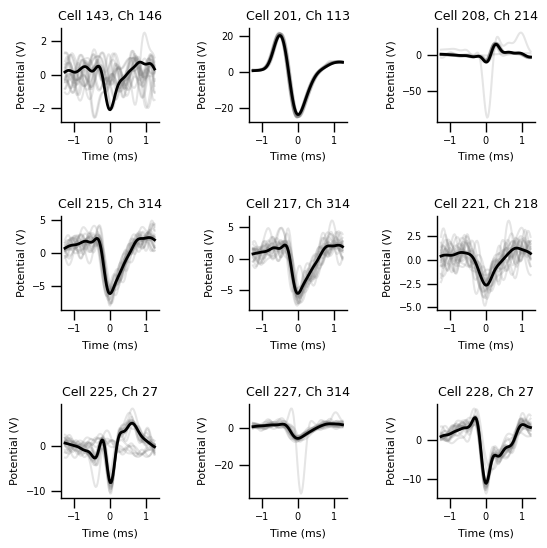

Batch 1 / 38 | Samples in window: 100


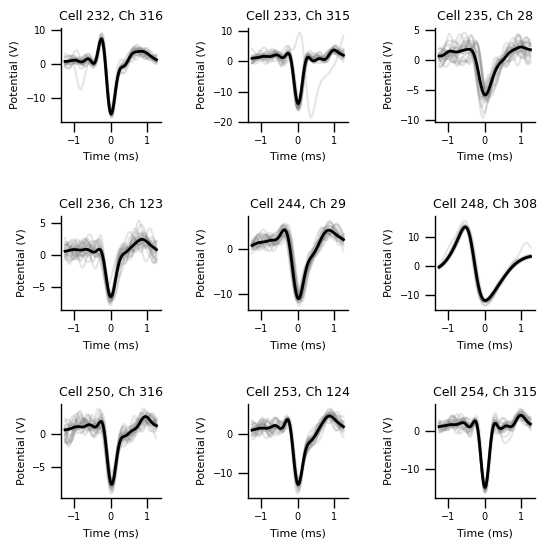

Batch 2 / 38 | Samples in window: 100


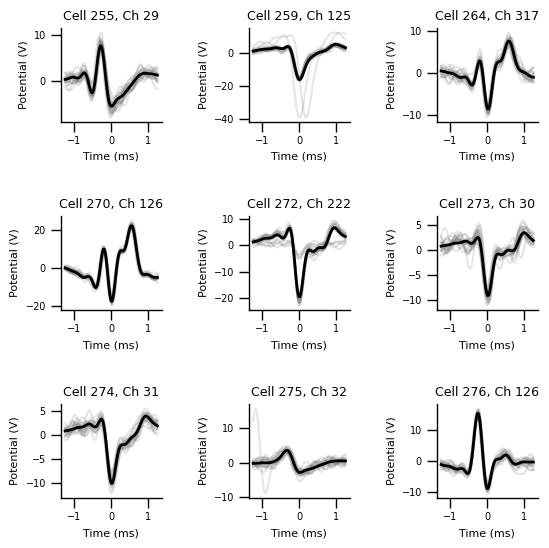

Batch 3 / 38 | Samples in window: 100


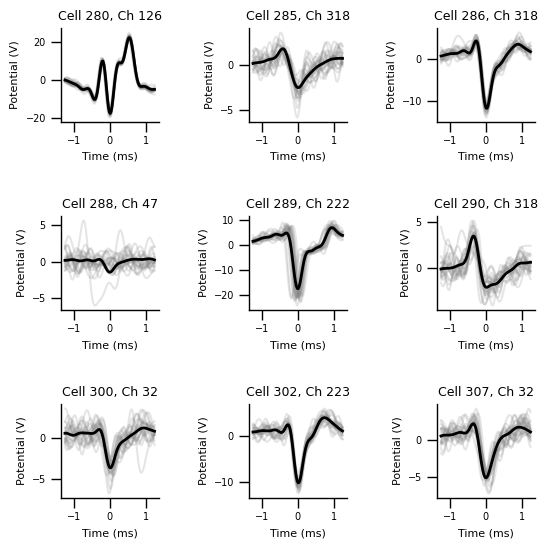

Batch 4 / 38 | Samples in window: 100


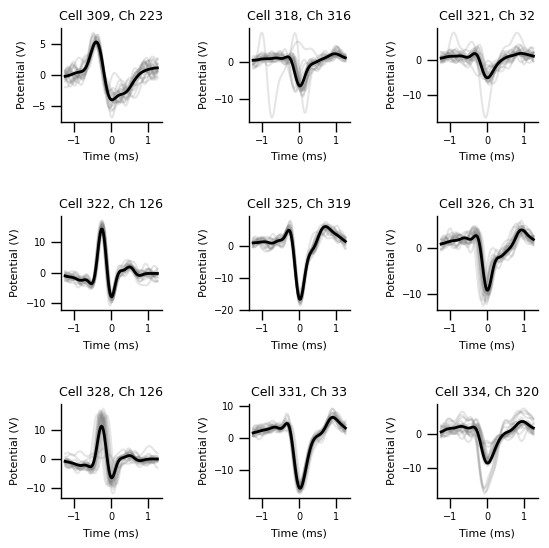

Batch 5 / 38 | Samples in window: 100


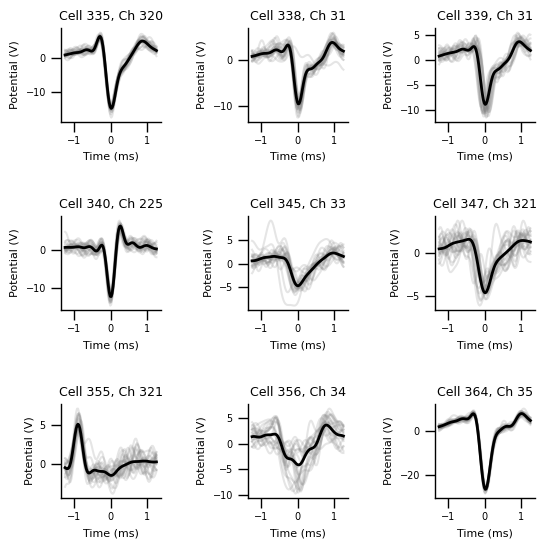

Batch 6 / 38 | Samples in window: 100


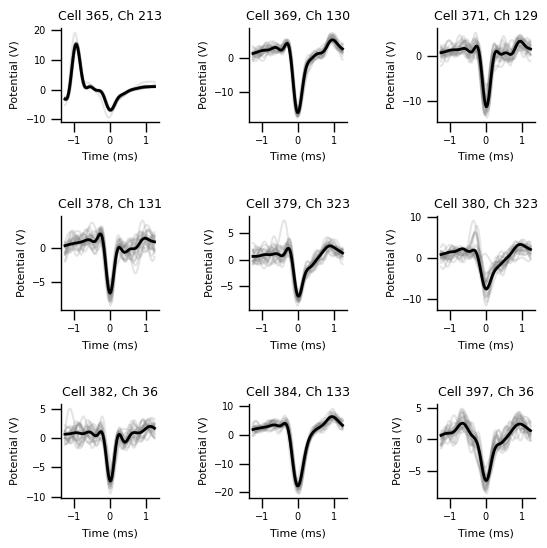

Batch 7 / 38 | Samples in window: 100


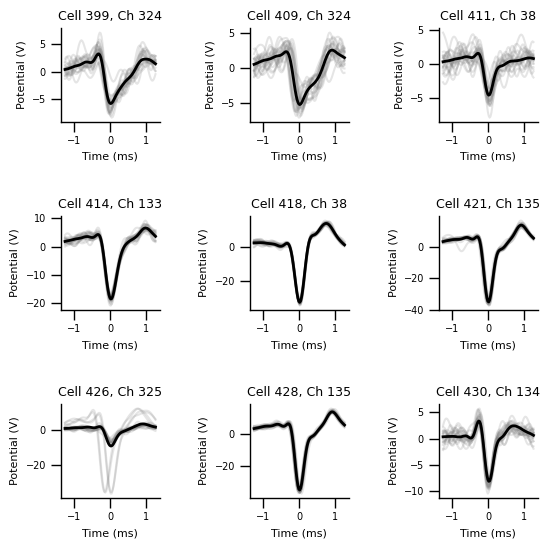

Batch 8 / 38 | Samples in window: 100


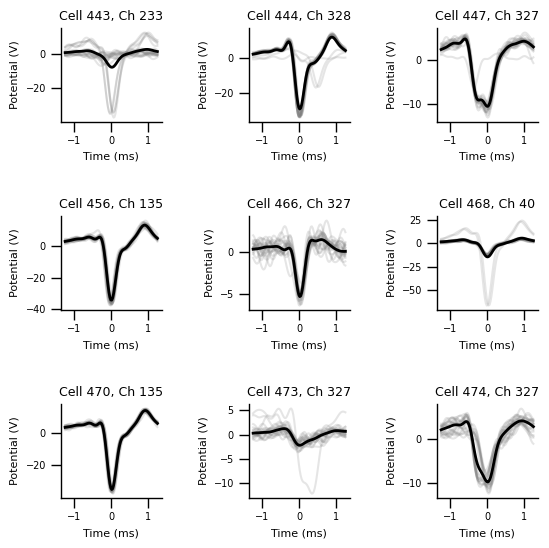

Batch 9 / 38 | Samples in window: 100


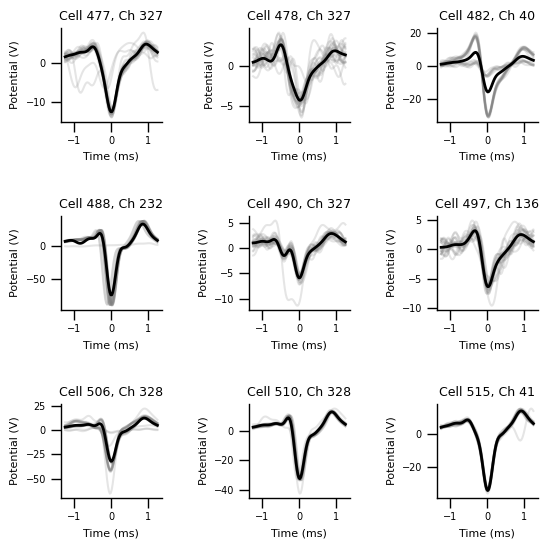

Batch 10 / 38 | Samples in window: 100


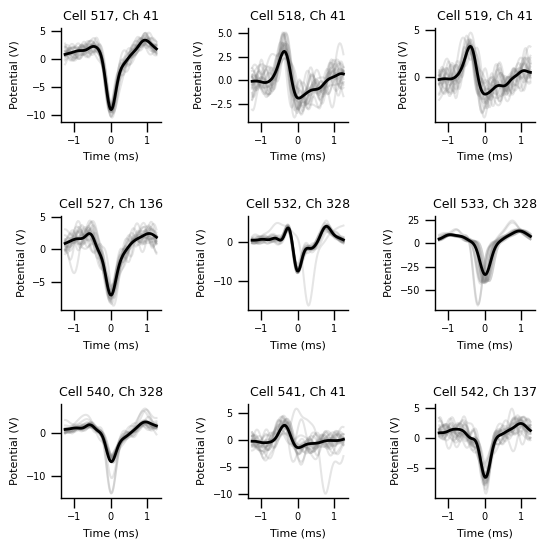

Batch 11 / 38 | Samples in window: 100


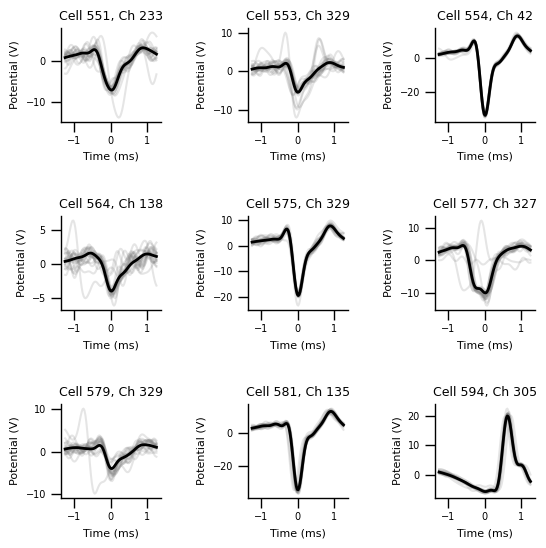

Batch 12 / 38 | Samples in window: 100


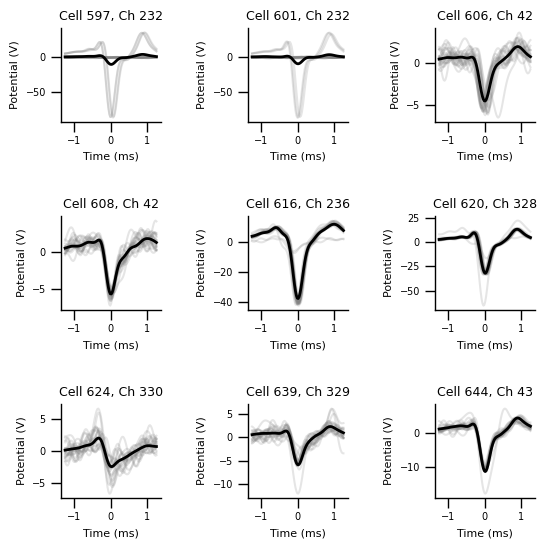

Batch 13 / 38 | Samples in window: 100


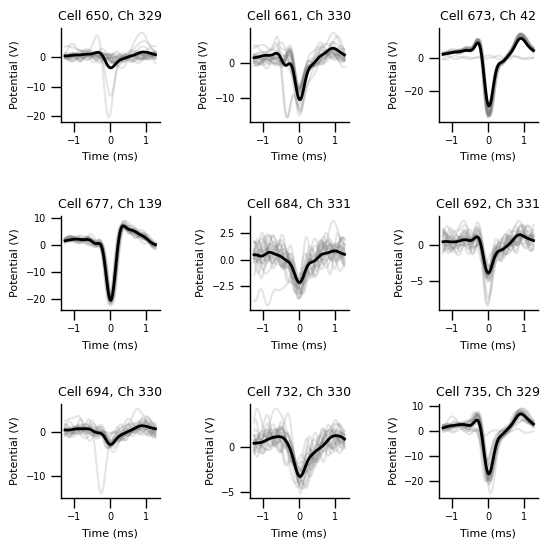

Batch 14 / 38 | Samples in window: 100


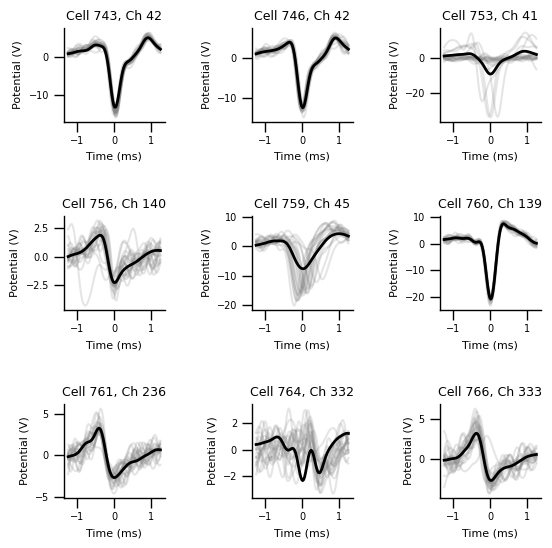

Batch 15 / 38 | Samples in window: 100


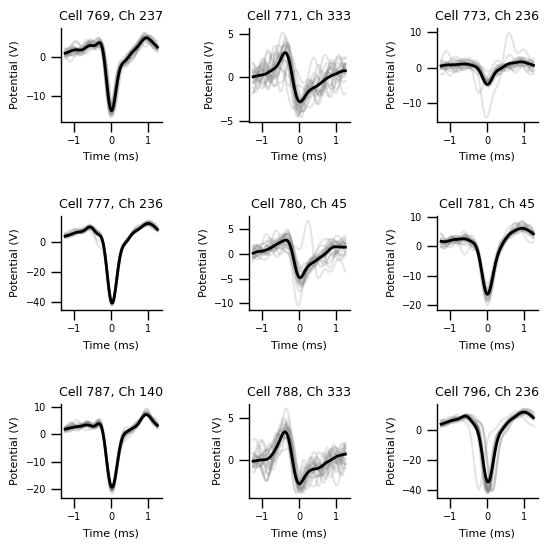

Batch 16 / 38 | Samples in window: 100


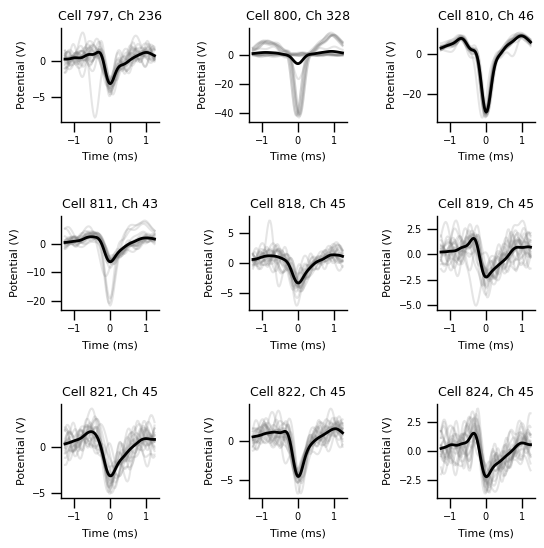

Batch 17 / 38 | Samples in window: 100


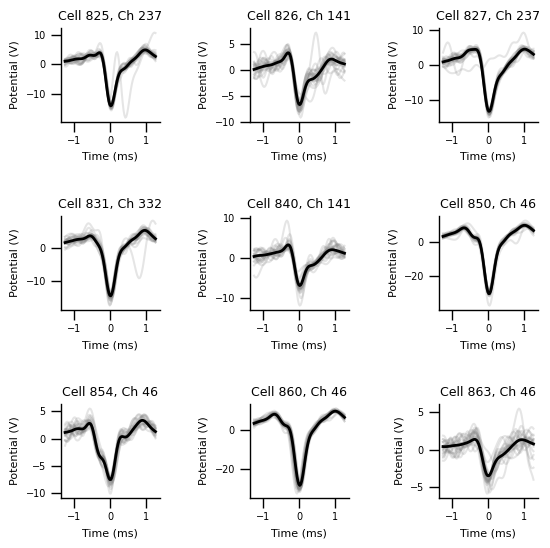

Batch 18 / 38 | Samples in window: 100


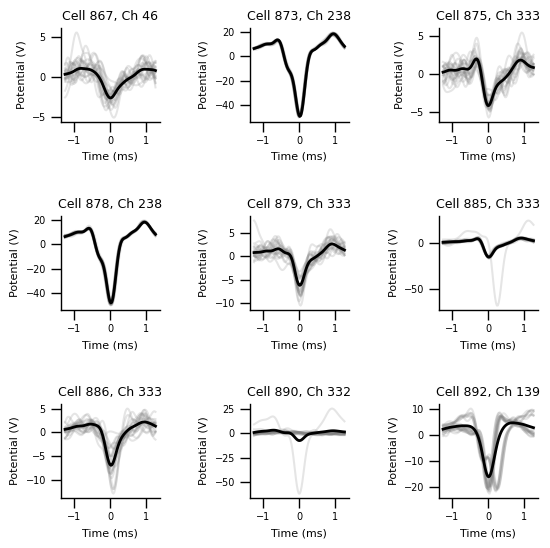

Batch 19 / 38 | Samples in window: 100


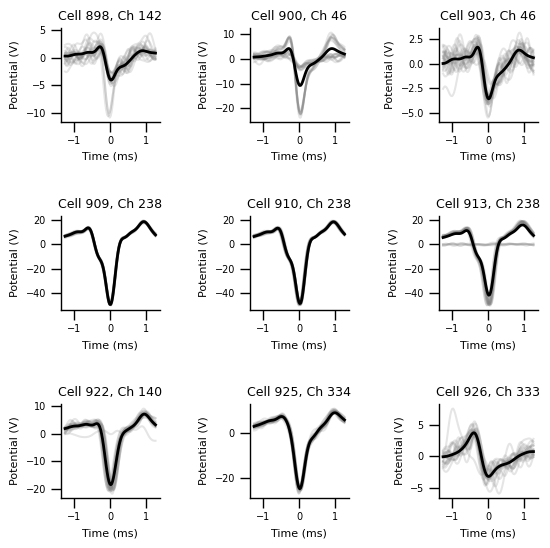

Batch 20 / 38 | Samples in window: 100


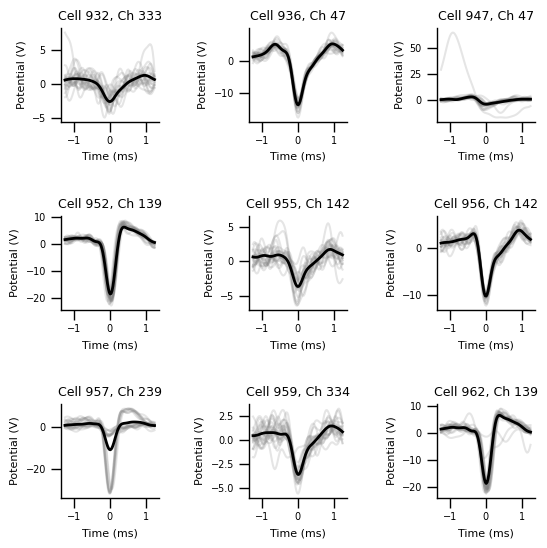

Batch 21 / 38 | Samples in window: 100


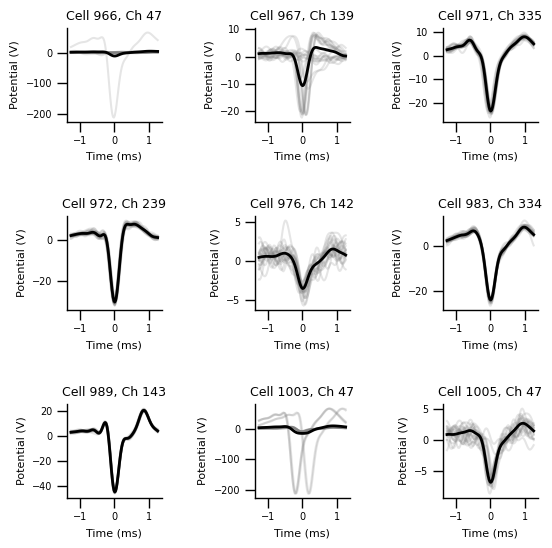

Batch 22 / 38 | Samples in window: 100


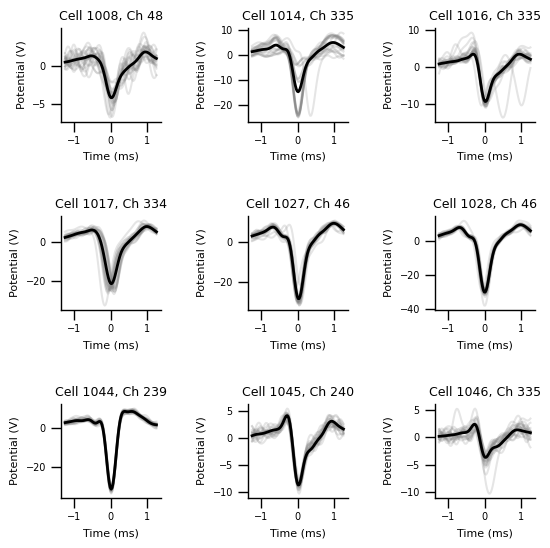

Batch 23 / 38 | Samples in window: 100


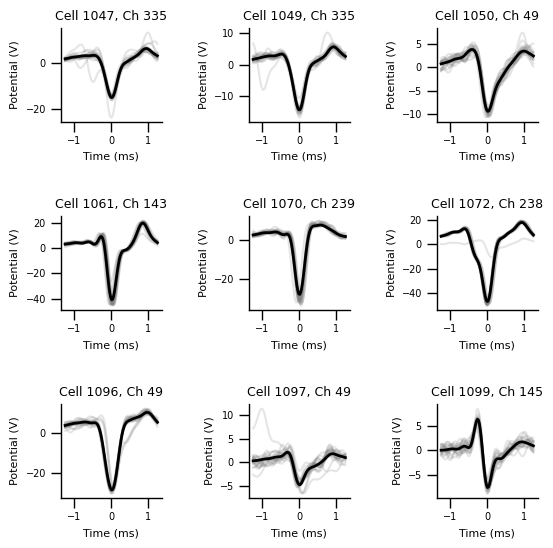

Batch 24 / 38 | Samples in window: 100


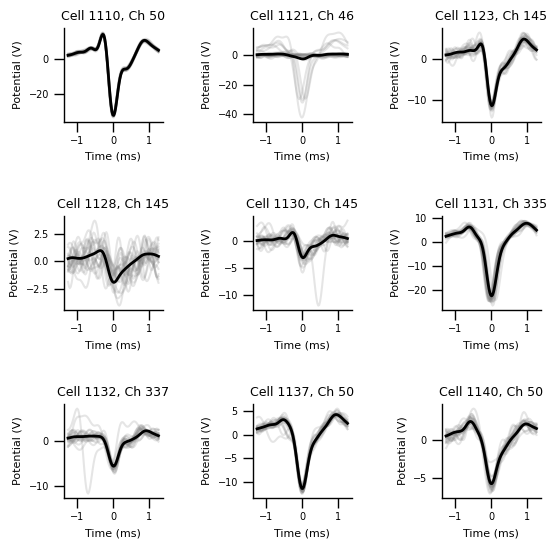

Batch 25 / 38 | Samples in window: 100


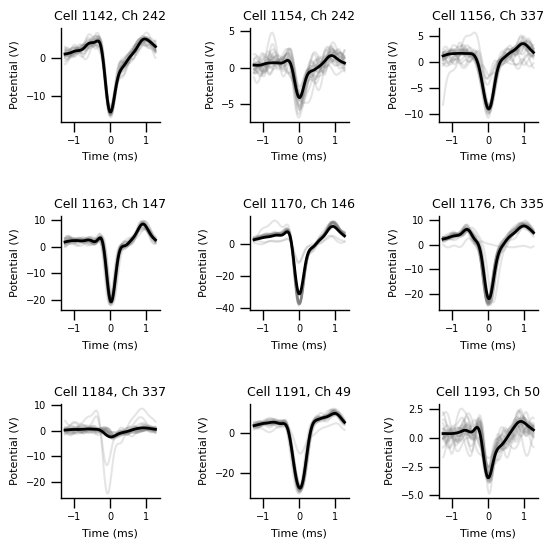

Batch 26 / 38 | Samples in window: 100


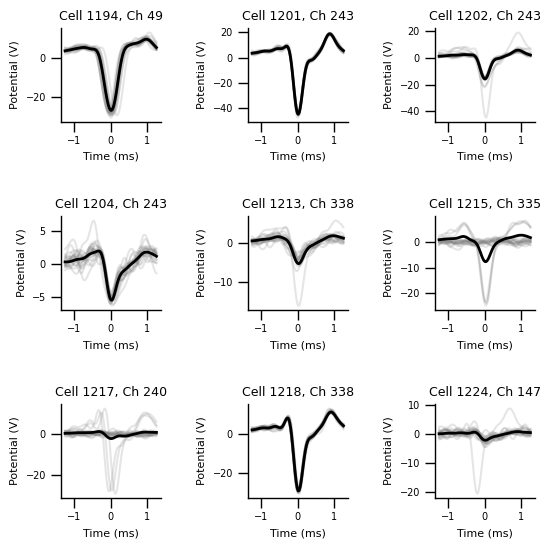

Batch 27 / 38 | Samples in window: 100


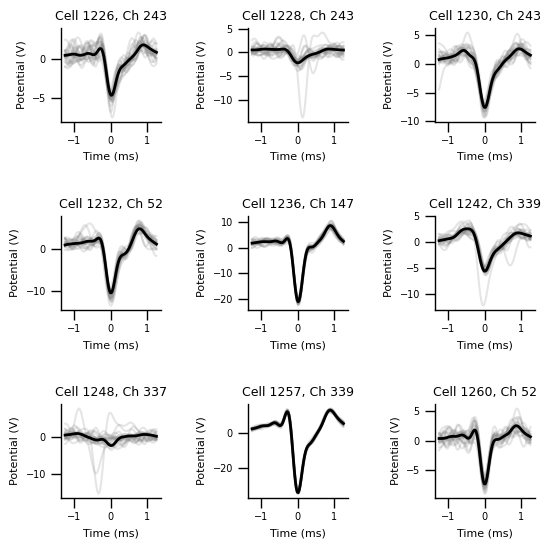

Batch 28 / 38 | Samples in window: 100


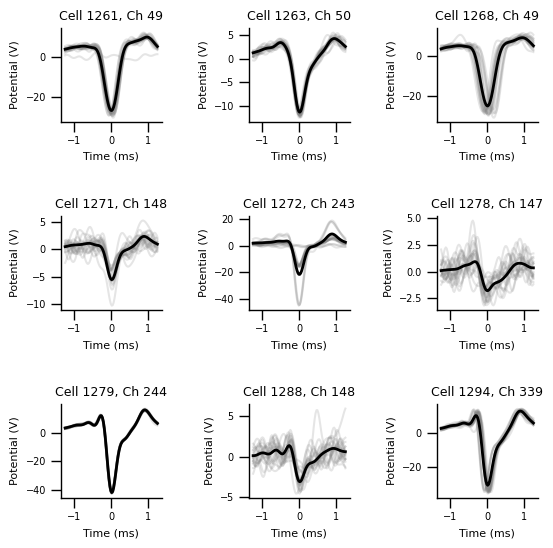

Batch 29 / 38 | Samples in window: 100


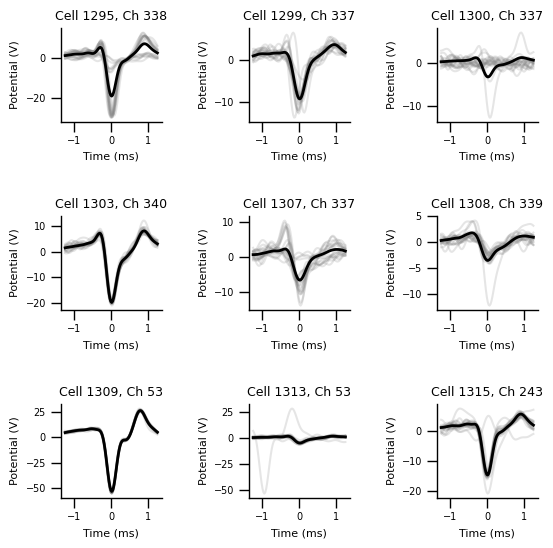

Batch 30 / 38 | Samples in window: 100


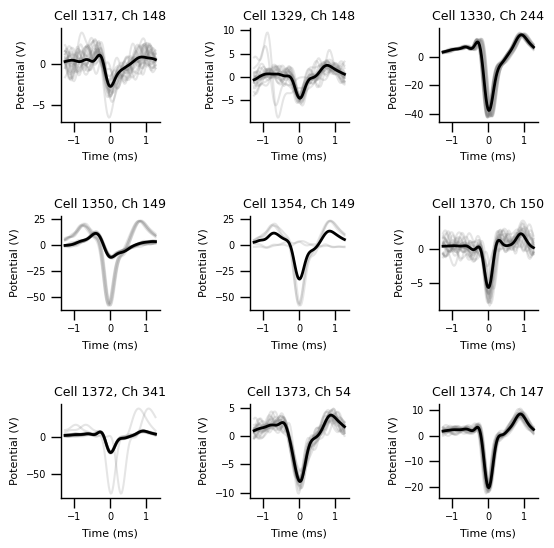

Batch 31 / 38 | Samples in window: 100


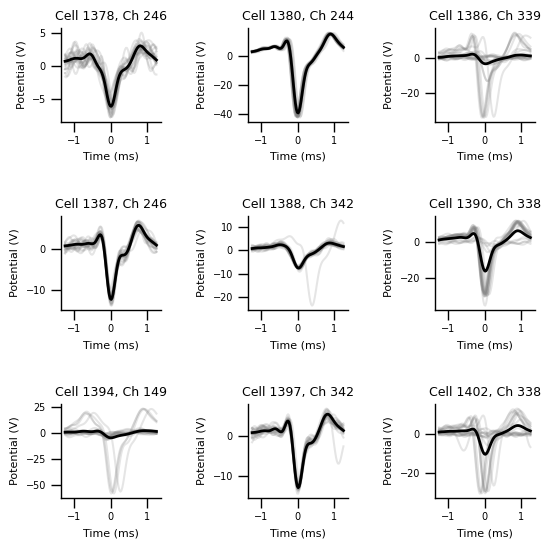

Batch 32 / 38 | Samples in window: 100


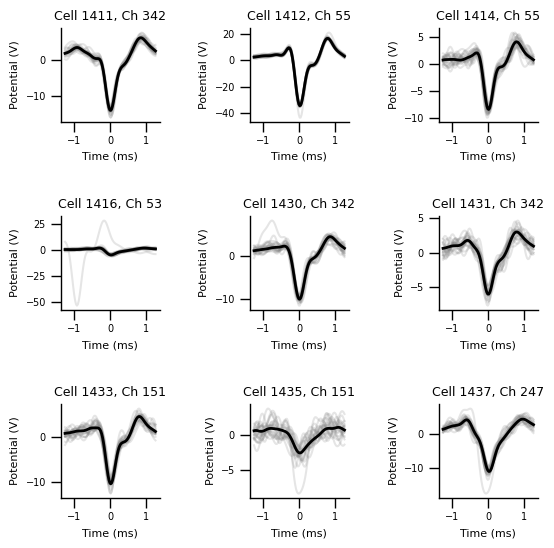

Batch 33 / 38 | Samples in window: 100


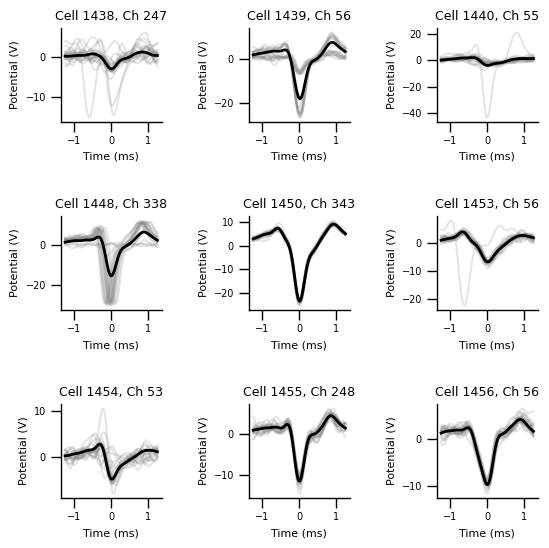

Batch 34 / 38 | Samples in window: 100


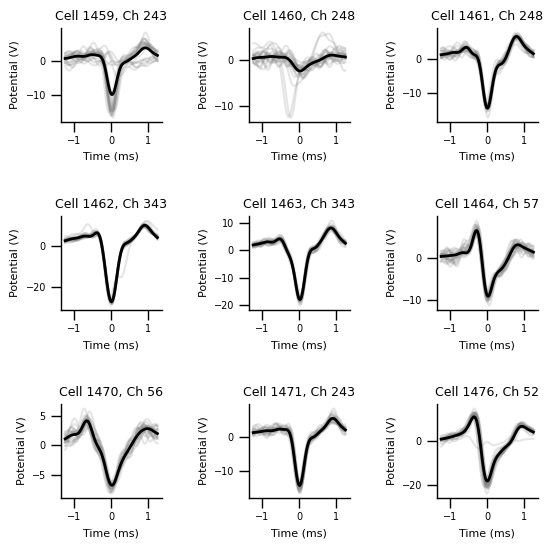

Batch 35 / 38 | Samples in window: 100


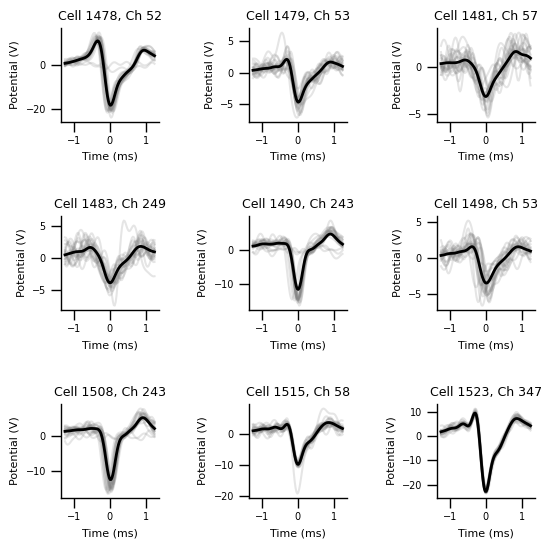

Batch 36 / 38 | Samples in window: 100


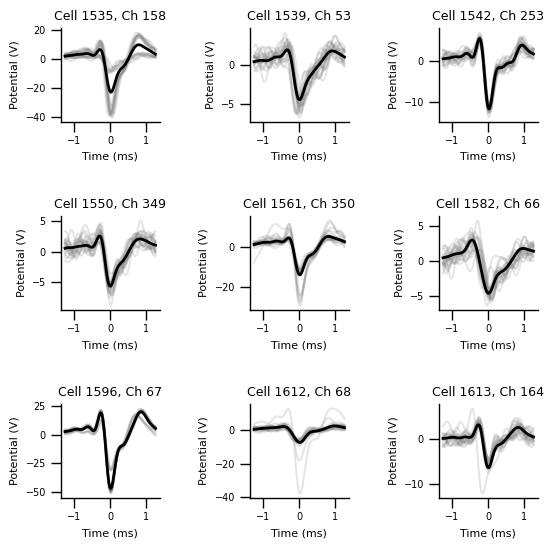

Batch 37 / 38 | Samples in window: 100


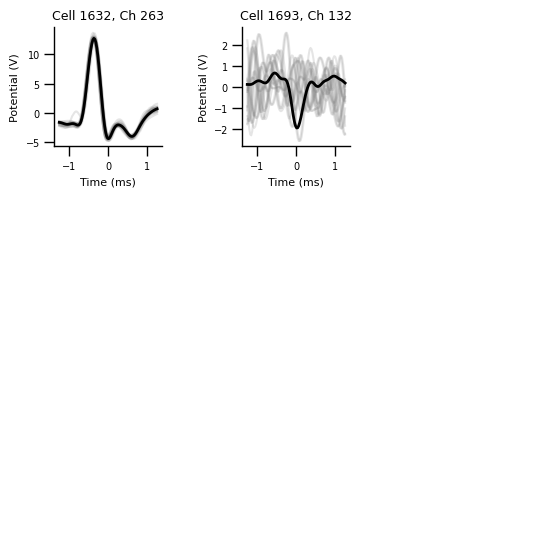

Batch 38 / 38 | Samples in window: 100
CPU times: user 1min 9s, sys: 35.6 s, total: 1min 45s
Wall time: 1min 38s


In [57]:
%%time
ms_before, ms_after, centered_len, max_chids_s = plot_batched_cell_waveforms(
    We=We_s,
    single_units=single_u_s,
    duration_ms=2.5,
    NSPIKE=20,
    cells_per_fig=9
)

#### All waveforms (evoked)

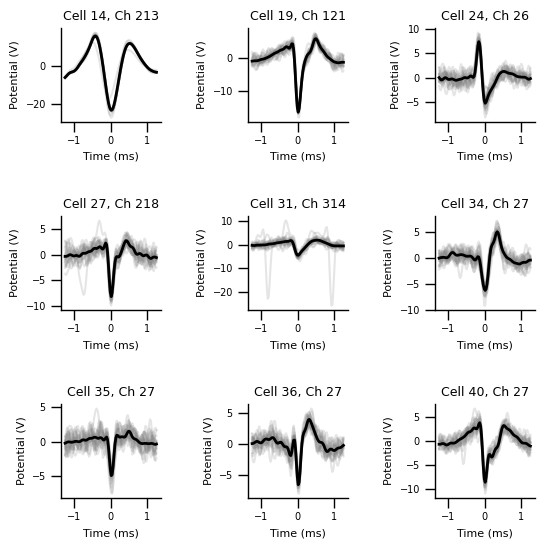

Batch 1 / 43 | Samples in window: 50


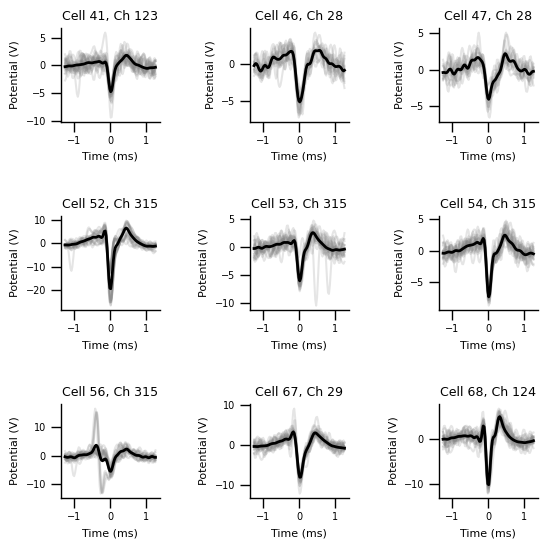

Batch 2 / 43 | Samples in window: 50


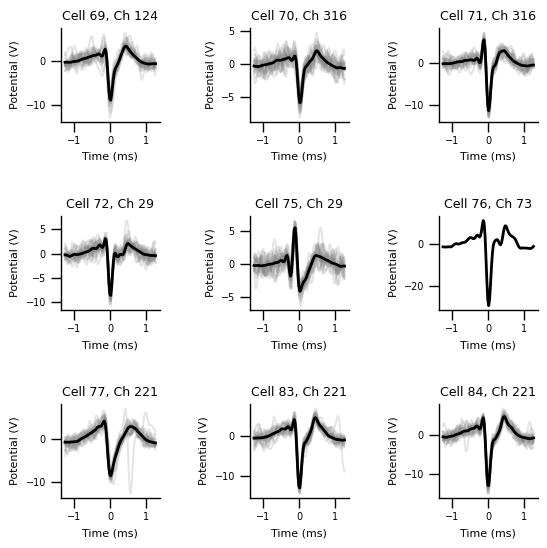

Batch 3 / 43 | Samples in window: 50


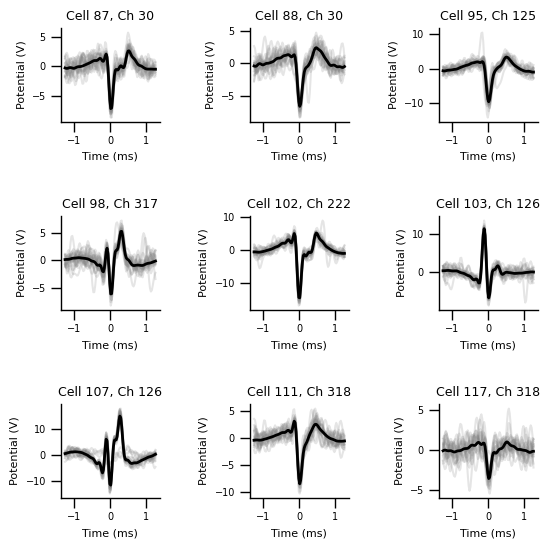

Batch 4 / 43 | Samples in window: 50


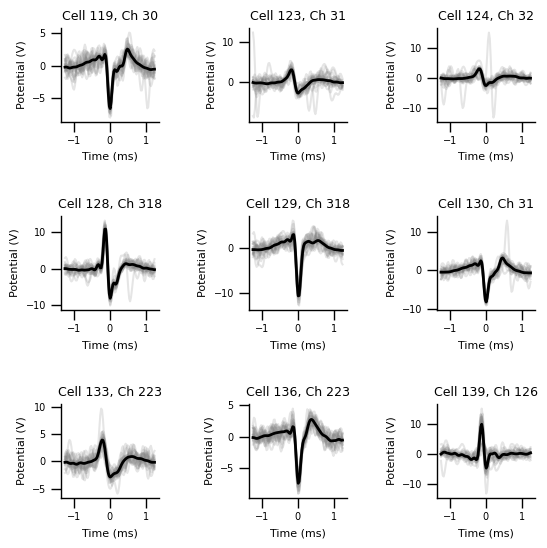

Batch 5 / 43 | Samples in window: 50


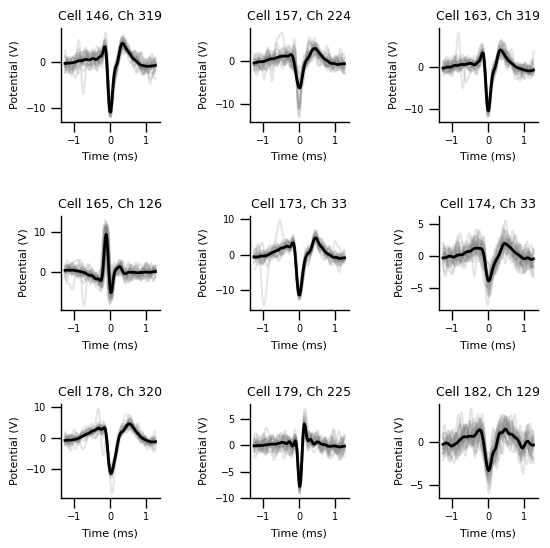

Batch 6 / 43 | Samples in window: 50


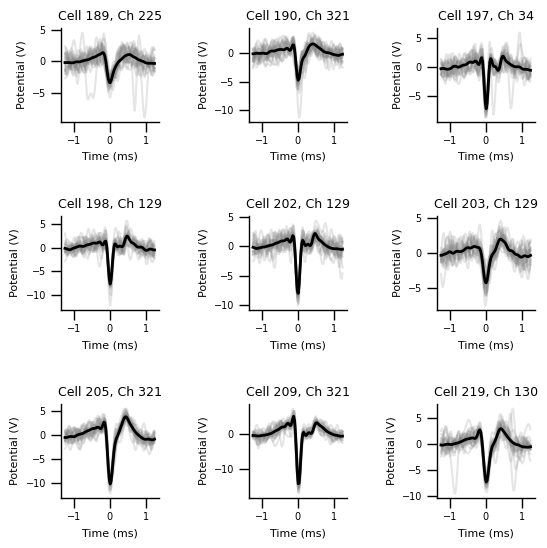

Batch 7 / 43 | Samples in window: 50


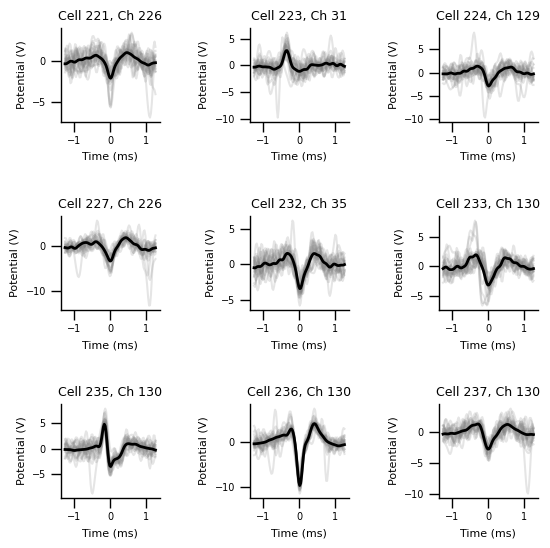

Batch 8 / 43 | Samples in window: 50


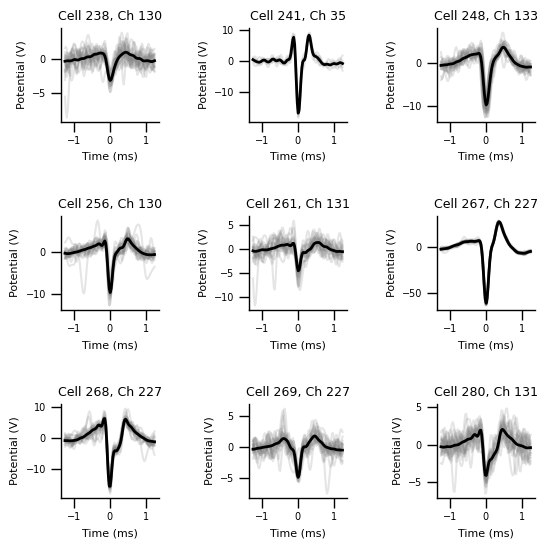

Batch 9 / 43 | Samples in window: 50


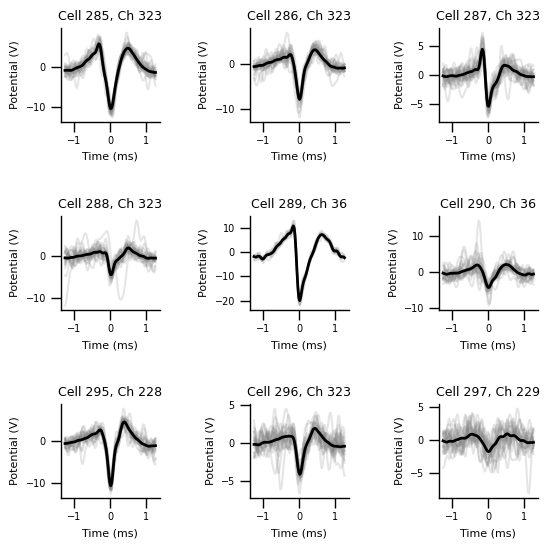

Batch 10 / 43 | Samples in window: 50


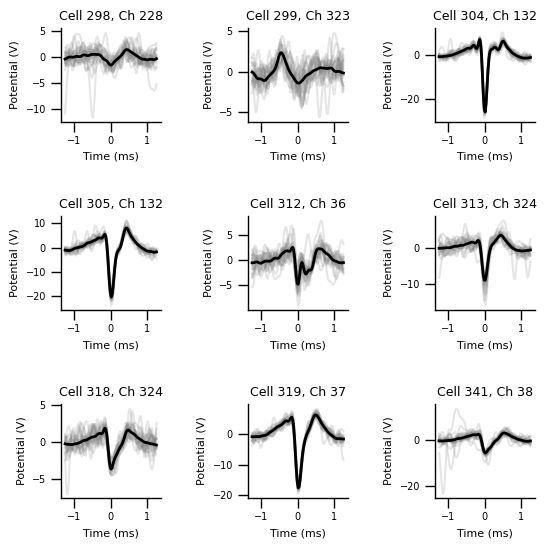

Batch 11 / 43 | Samples in window: 50


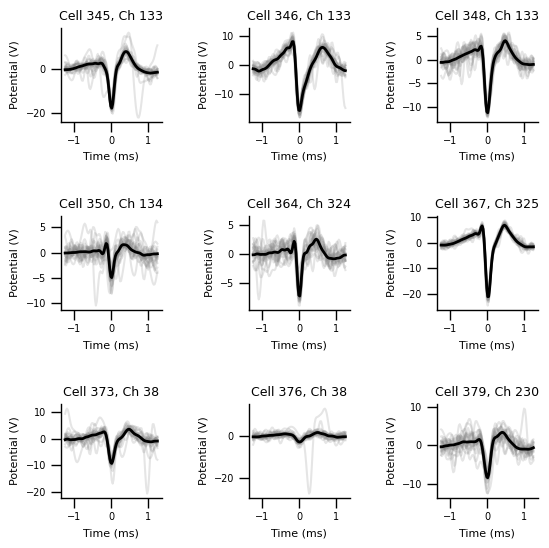

Batch 12 / 43 | Samples in window: 50


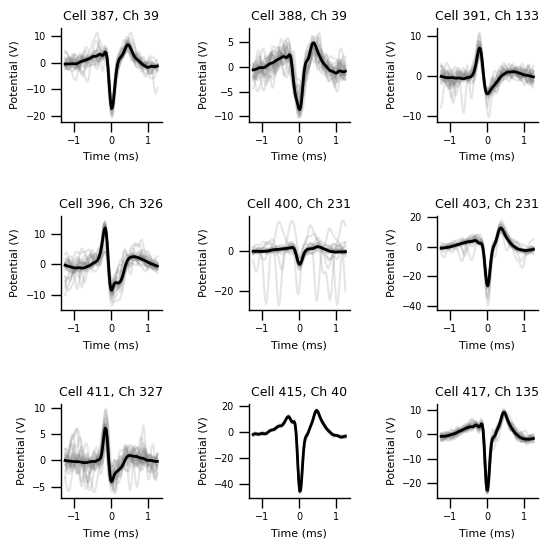

Batch 13 / 43 | Samples in window: 50


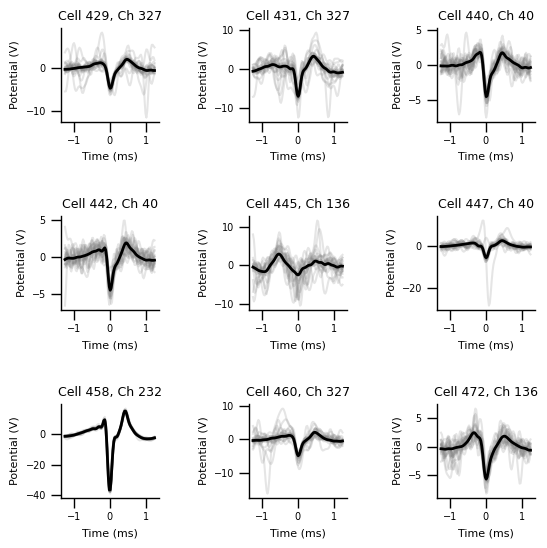

Batch 14 / 43 | Samples in window: 50


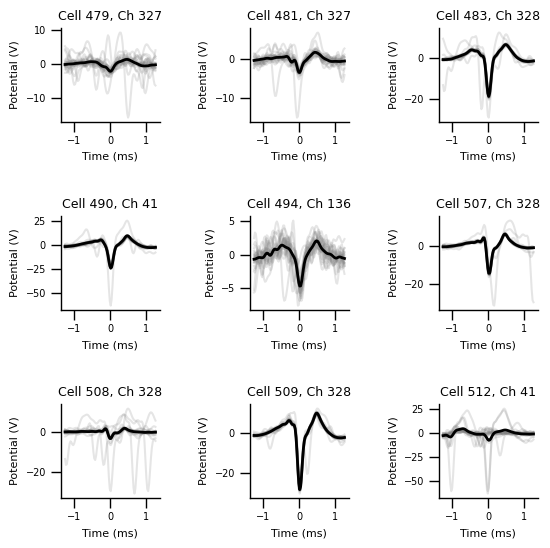

Batch 15 / 43 | Samples in window: 50


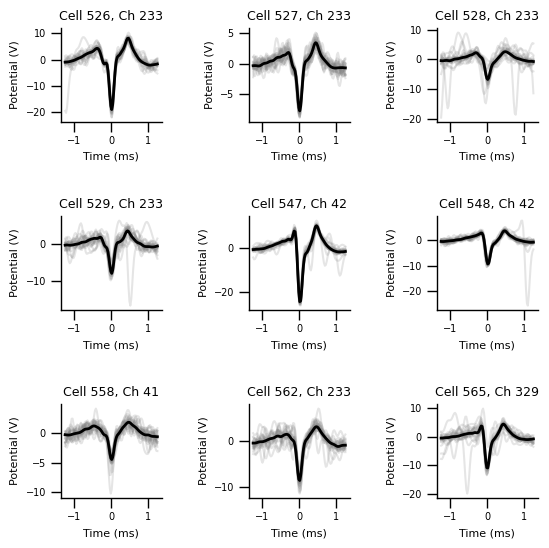

Batch 16 / 43 | Samples in window: 50


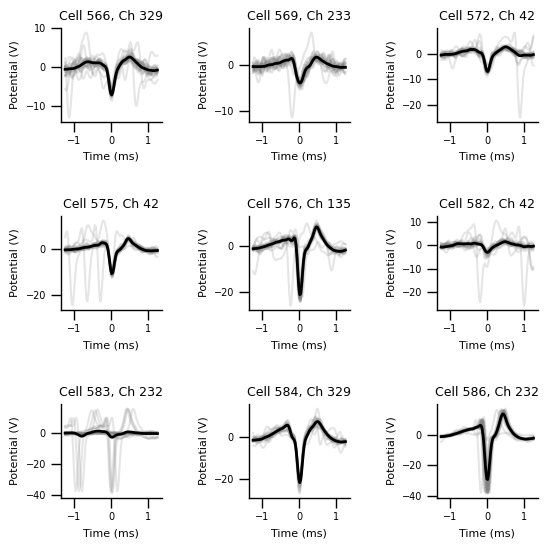

Batch 17 / 43 | Samples in window: 50


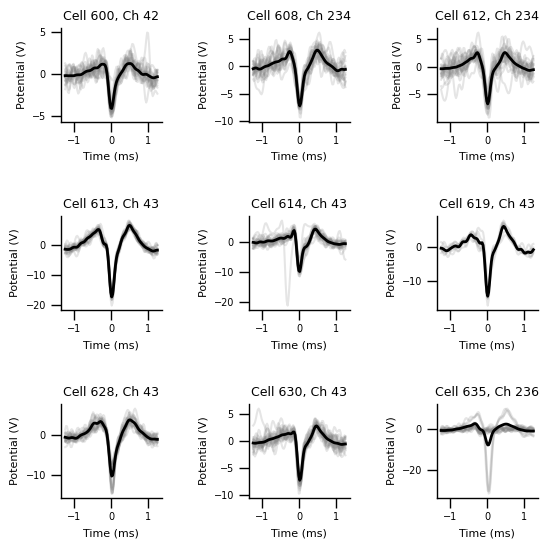

Batch 18 / 43 | Samples in window: 50


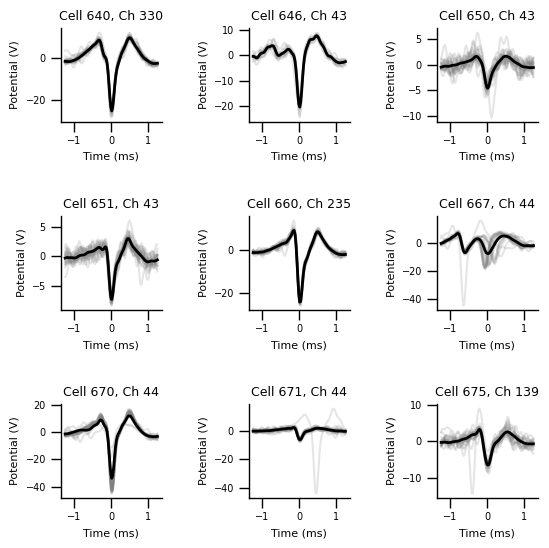

Batch 19 / 43 | Samples in window: 50


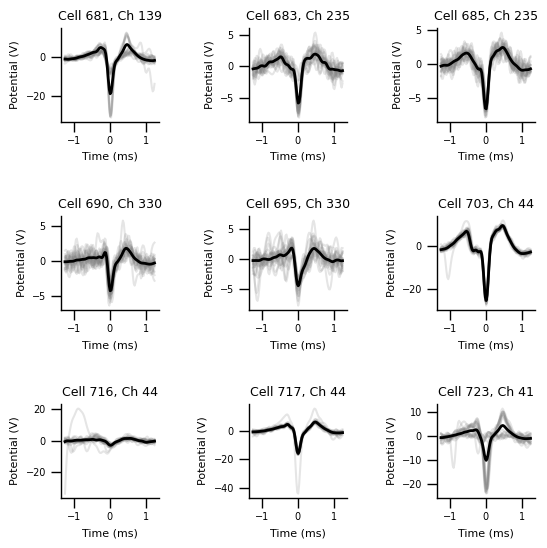

Batch 20 / 43 | Samples in window: 50


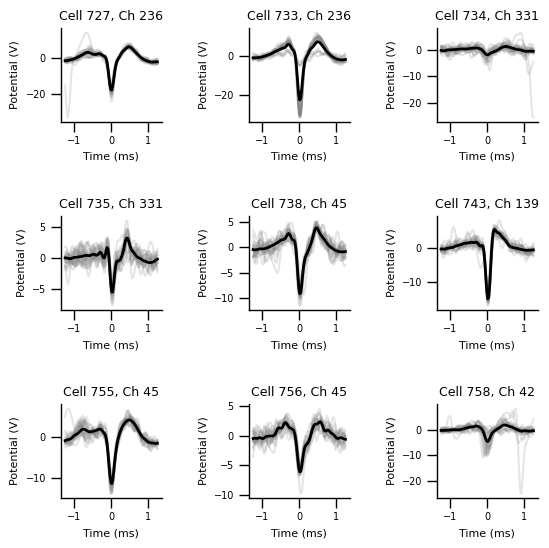

Batch 21 / 43 | Samples in window: 50


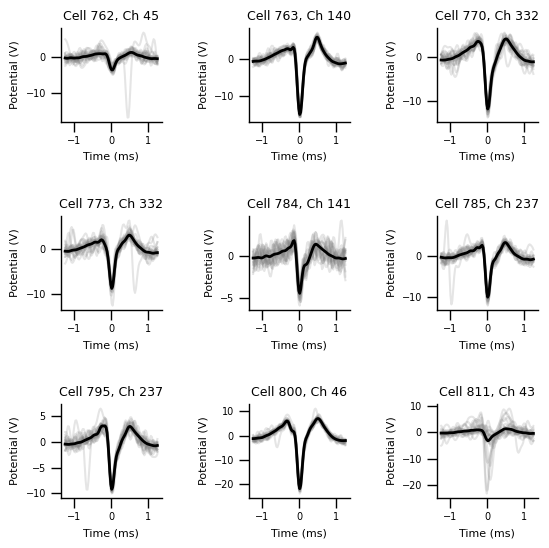

Batch 22 / 43 | Samples in window: 50


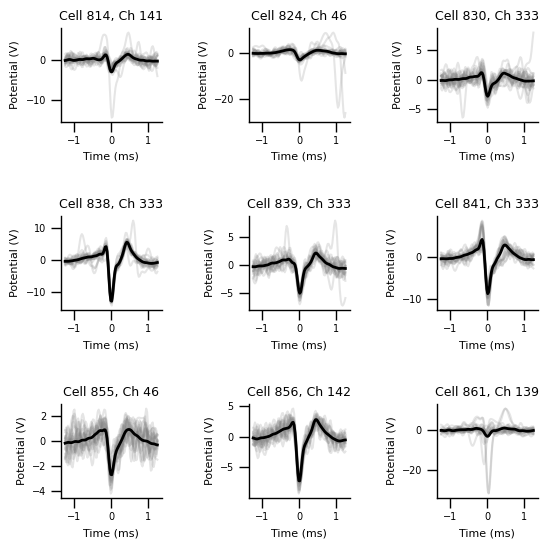

Batch 23 / 43 | Samples in window: 50


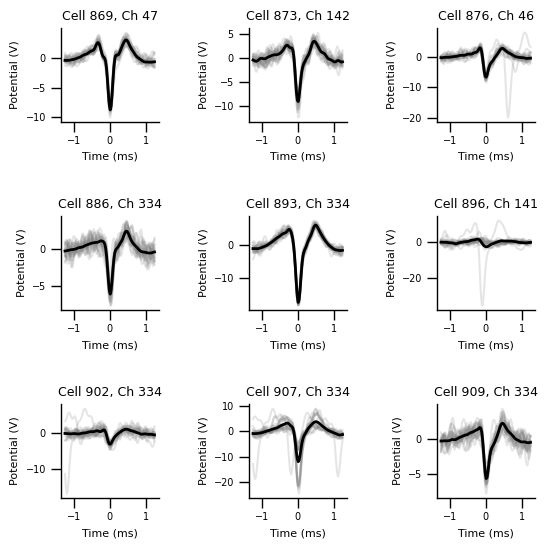

Batch 24 / 43 | Samples in window: 50


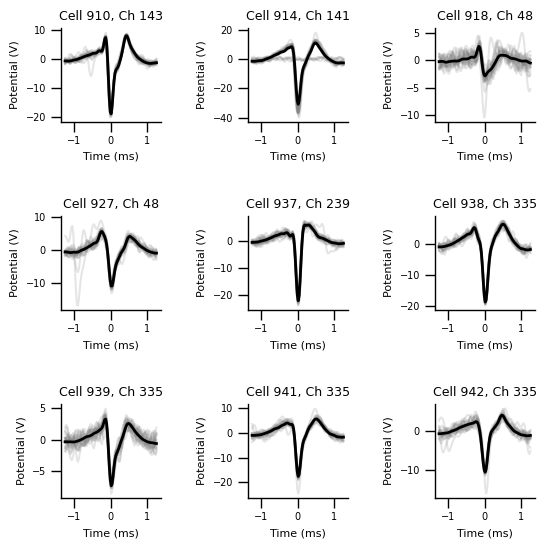

Batch 25 / 43 | Samples in window: 50


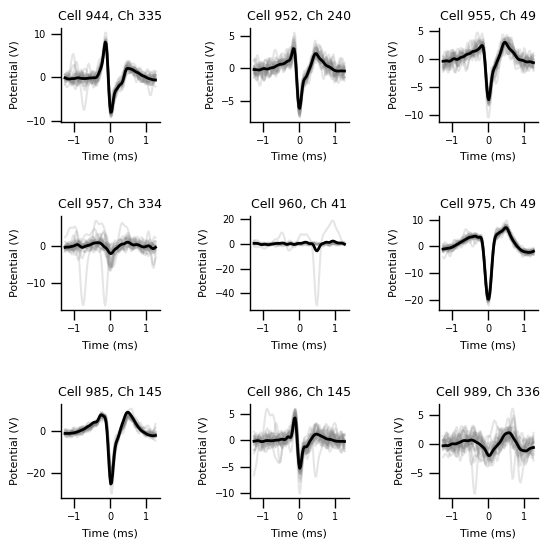

Batch 26 / 43 | Samples in window: 50


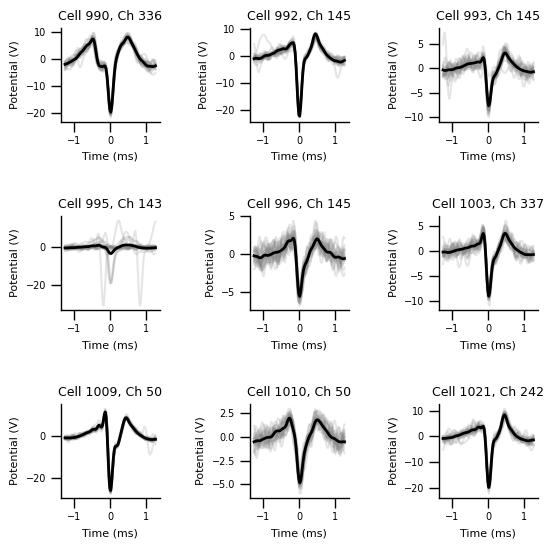

Batch 27 / 43 | Samples in window: 50


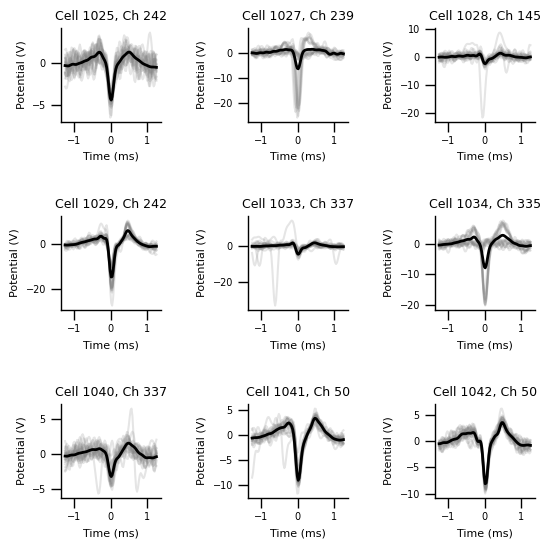

Batch 28 / 43 | Samples in window: 50


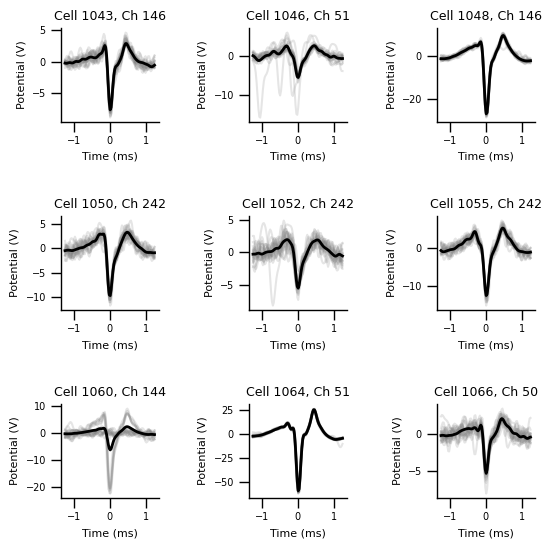

Batch 29 / 43 | Samples in window: 50


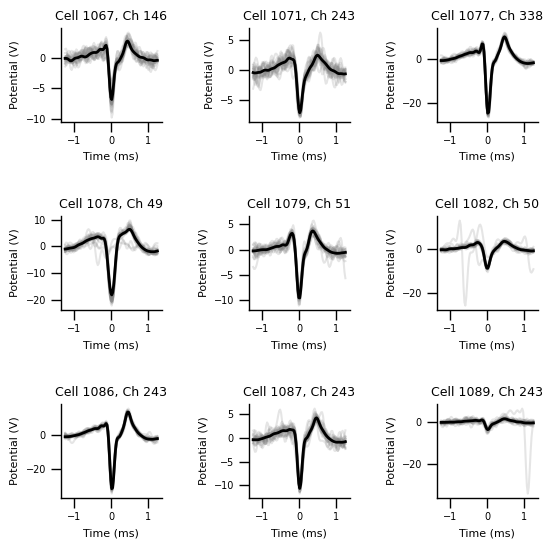

Batch 30 / 43 | Samples in window: 50


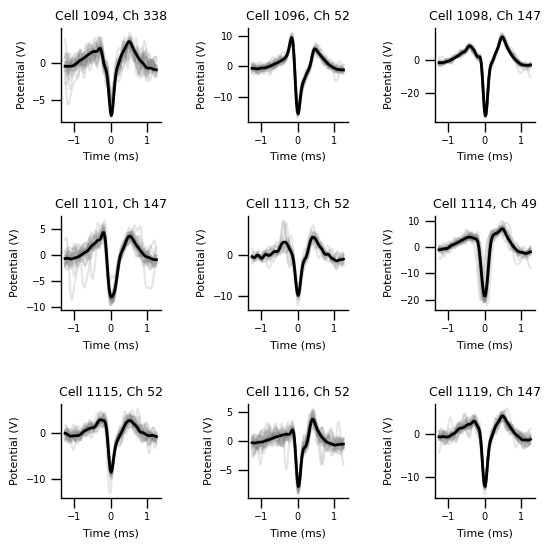

Batch 31 / 43 | Samples in window: 50


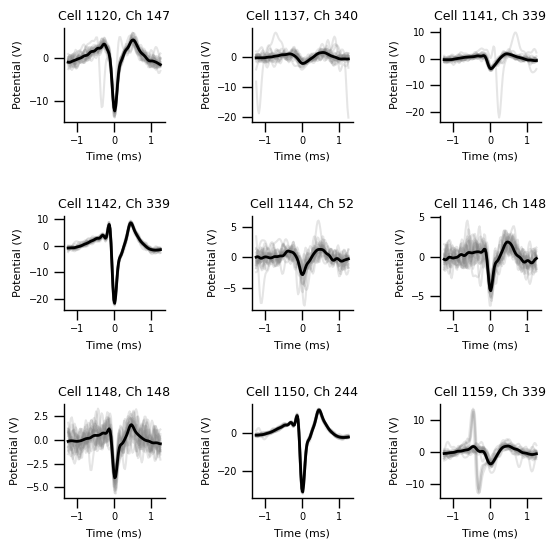

Batch 32 / 43 | Samples in window: 50


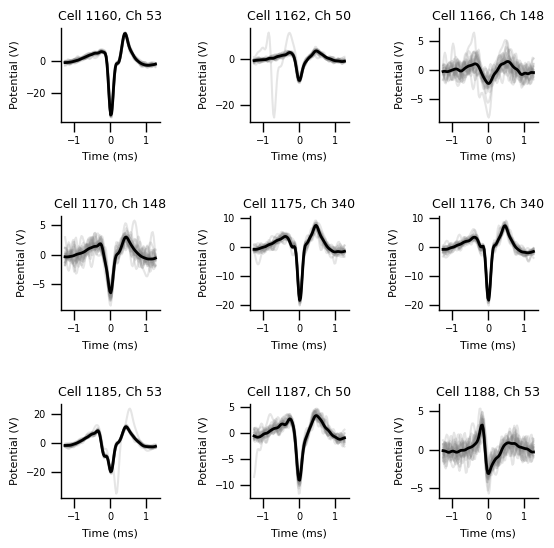

Batch 33 / 43 | Samples in window: 50


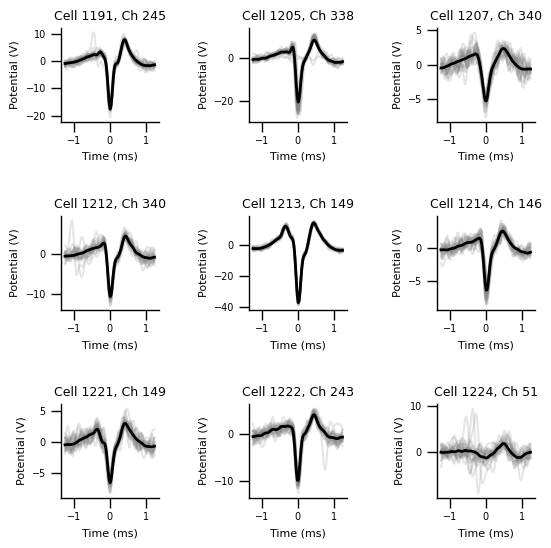

Batch 34 / 43 | Samples in window: 50


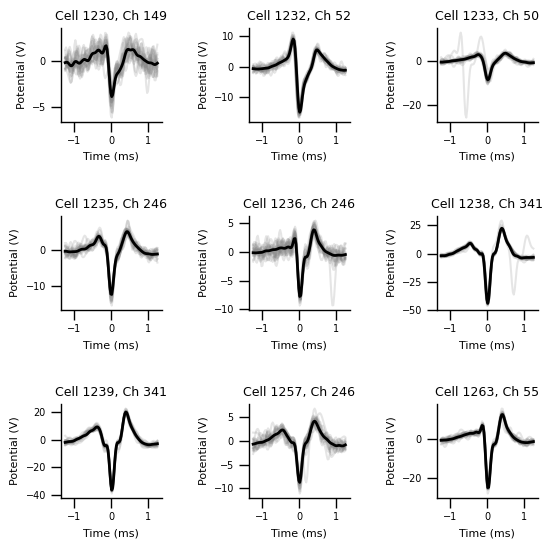

Batch 35 / 43 | Samples in window: 50


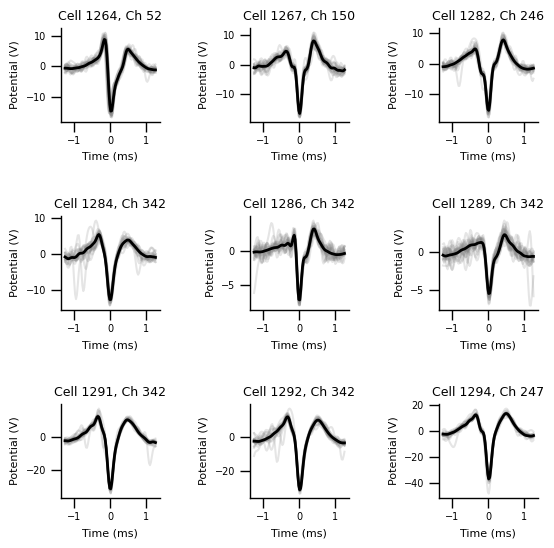

Batch 36 / 43 | Samples in window: 50


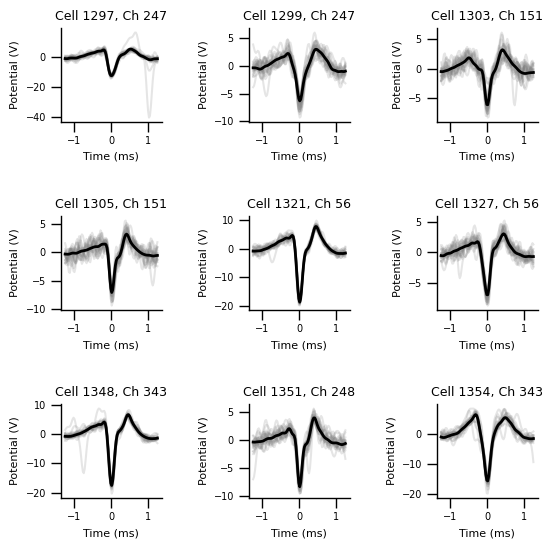

Batch 37 / 43 | Samples in window: 50


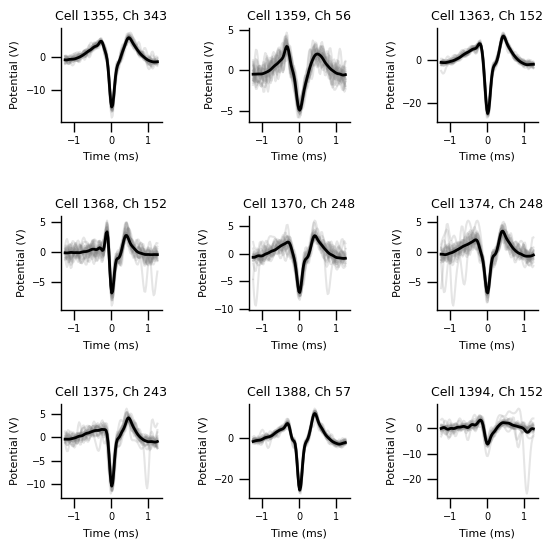

Batch 38 / 43 | Samples in window: 50


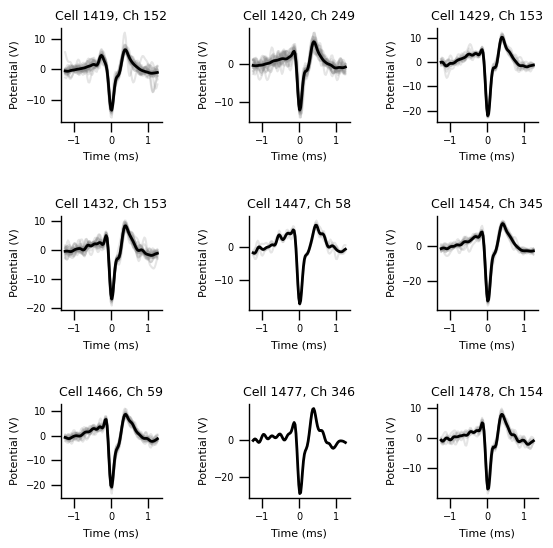

Batch 39 / 43 | Samples in window: 50


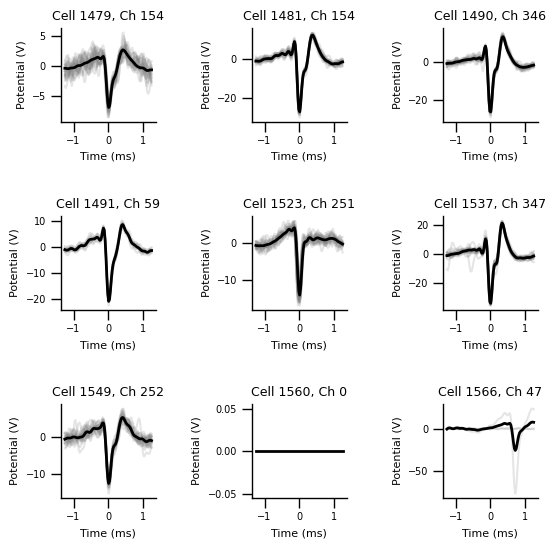

Batch 40 / 43 | Samples in window: 50


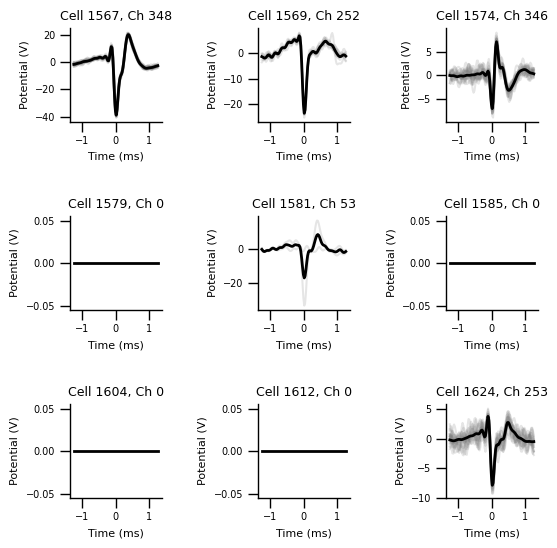

Batch 41 / 43 | Samples in window: 50


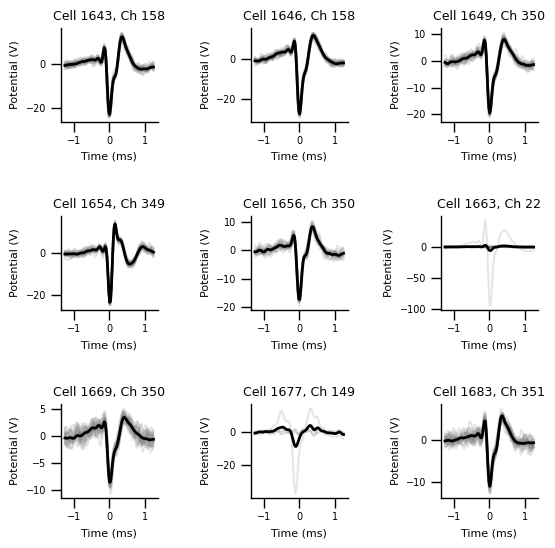

Batch 42 / 43 | Samples in window: 50


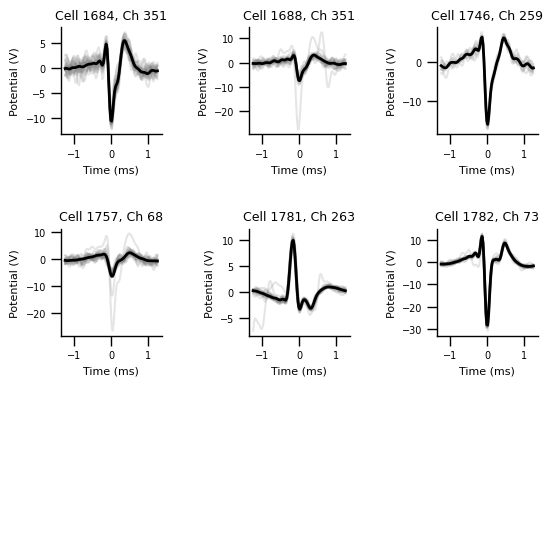

Batch 43 / 43 | Samples in window: 50
CPU times: user 48.8 s, sys: 23.3 s, total: 1min 12s
Wall time: 1min 4s


In [58]:
%%time
ms_before, ms_after, centered_len, max_chids_e = plot_batched_cell_waveforms(
    We=We_e,
    single_units=single_u_e,
    duration_ms=2.5,
    NSPIKE=20,
    cells_per_fig=9
)

## Five waveforms type

Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20


Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20
Waveforms count: 20


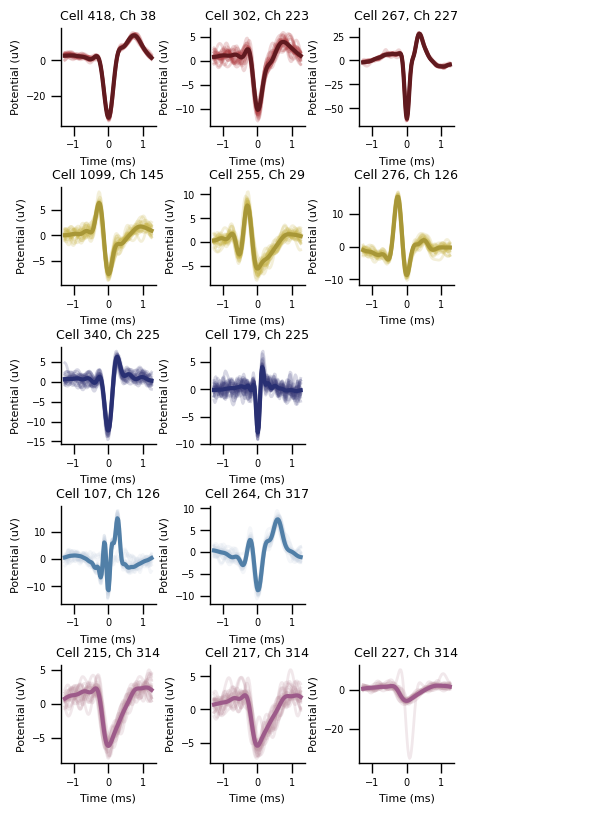

In [125]:
# setup plot parameters
N_SPIKES = 20

# setup figure colors
red = np.array([97, 26, 31, 100]) / 255
each_red = np.array([170, 48, 53, 100]) / 255
blue = np.array([41, 48, 115, 100]) / 255
each_blue = np.array([57, 58, 120, 100]) / 255
blue2 = np.array([81, 127, 167, 100]) / 255
each_blue2 = np.array([200, 211, 226, 100]) / 255
purple = np.array([157, 91, 138, 100]) / 255
each_purple = np.array([187, 142, 157, 100]) / 255

# setup plots
fig, ax = plt.subplots(5,4, figsize=(6,8))
time_axis = np.linspace(ms_before, ms_after, num=centered_len)

# plot regular spiking waveforms
plot_centered_waveform(We_s, cell_id=418, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[0,0],
    color_waveforms=each_red,
    color_template=red,
    max_chids=max_chids_s
)
plot_centered_waveform(We_s, cell_id=302, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[0,1],
    color_waveforms=each_red,
    color_template=red,
    max_chids=max_chids_s
)
plot_centered_waveform(We_e, cell_id=267, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[0,2],
    color_waveforms=each_red,
    color_template=red,
    max_chids=max_chids_e
)
ax[0,3].axis('off') # remove

# plot ositive waveforms
plot_centered_waveform(We_s, cell_id=1099, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[1,0],
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=max_chids_s
)
plot_centered_waveform(We_s, cell_id=255, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[1,1],
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=max_chids_s
)
plot_centered_waveform(We_s, cell_id=276, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[1,2],
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=max_chids_s
)
ax[1,3].axis('off') # remove

# plot fast spiking waveforms
plot_centered_waveform(We_s, cell_id=340, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[2,0],
    color_waveforms=each_blue,
    color_template=blue,
    max_chids=max_chids_s
)
plot_centered_waveform(We_e, cell_id=179, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[2,1],
    color_waveforms=each_blue,
    color_template=blue,
    max_chids=max_chids_e
)
ax[2,2].axis('off') # remove
ax[2,3].axis('off') # remove

# plot tri-phasic waveforms
plot_centered_waveform(We_e, cell_id=107, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[3,0],
    color_waveforms=each_blue2,
    color_template=blue2,
    max_chids=max_chids_e
)
plot_centered_waveform(We_s, cell_id=264, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[3,1],
    color_waveforms=each_blue2,
    color_template=blue2,
    max_chids=max_chids_s
)
ax[3,2].axis('off') # remove
ax[3,3].axis('off') # remove

# plot compound waveforms
plot_centered_waveform(We_s, cell_id=215, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[4,0],
    color_waveforms=each_purple,
    color_template=purple,
    max_chids=max_chids_s
)
plot_centered_waveform(We_s, cell_id=217, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[4,1],
    color_waveforms=each_purple,
    color_template=purple,
    max_chids=max_chids_s
)
plot_centered_waveform(We_s, cell_id=227, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[4,2],
    color_waveforms=each_purple,
    color_template=purple,
    max_chids=max_chids_s
)
ax[4,3].axis('off') # remove
plt.tight_layout(pad=0.1)

# save
#plt.savefig("figures/0_validation/5_spikes/fig3c_five_temporal_profiles.svg", dpi=300, **savefig_cfg)


Waveforms count: 100
Waveforms count: 100
Waveforms count: 100
Waveforms count: 5
Waveforms count: 100


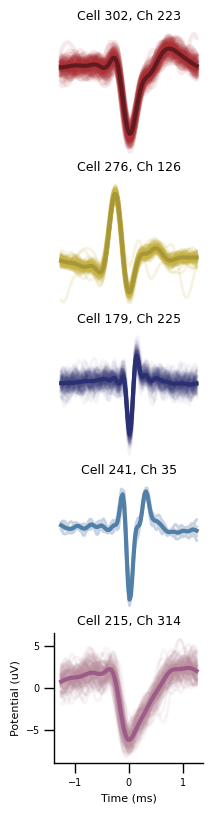

In [130]:
# setup plot parameters
N_SPIKES = 100

# setup figure colors
red = np.array([97, 26, 31, 100]) / 255
each_red = np.array([170, 48, 53, 100]) / 255
blue = np.array([41, 48, 115, 100]) / 255
each_blue = np.array([57, 58, 120, 100]) / 255
blue2 = np.array([81, 127, 167, 100]) / 255
each_blue2 = np.array([200, 211, 226, 100]) / 255
purple = np.array([157, 91, 138, 100]) / 255
each_purple = np.array([187, 142, 157, 100]) / 255

# setup plots
fig, ax = plt.subplots(5,1, figsize=(2,8))
time_axis = np.linspace(ms_before, ms_after, num=centered_len)

# plot regular spiking waveforms
plot_centered_waveform(We_s, cell_id=302, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[0], color_waveforms=each_red, 
                       color_template=red, max_chids=max_chids_s, alpha=0.1, linewidth=3)
ax[0].axis('off') # remove

# plot positive waveforms
plot_centered_waveform(We_s, cell_id=276, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[1],
    color_waveforms=(199/255, 179/255, 68/255, 100/255), color_template=(168/255, 151/255, 55/255, 100/255), max_chids=max_chids_s, alpha=0.15)
ax[1].axis('off') # remove

# plot fast spiking waveforms
plot_centered_waveform(We_e, cell_id=179, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[2],
    color_waveforms=each_blue, color_template=blue, max_chids=max_chids_e, alpha=0.05)
ax[2].axis('off') # remove

# plot tri-phasic waveforms
plot_centered_waveform(We_e, cell_id=241, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[3],
    color_waveforms=each_blue2, color_template=blue2, max_chids=max_chids_e, alpha=1)
ax[3].axis('off') # remove

# plot compound waveforms
plot_centered_waveform(We_s, cell_id=215, nspike=N_SPIKES, centered_len=100, time_axis=time_axis, ax=ax[4],
    color_waveforms=each_purple, color_template=purple, max_chids=max_chids_s, alpha=0.1)
#ax[4].axis('off') # remove
plt.tight_layout(pad=0.1)

# save
plt.savefig("figures/0_validation/5_spikes/fig3c_five_temporal_profiles.svg", dpi=300, **savefig_cfg)
